**Lab2-DL: D1-MR-demens-klassifikasjon.ipynb** (ELMED219) | Prioritet: 2 (anbefalt)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arvidl/ELMED219-2026/blob/main/Lab2-DL/notebooks/D1-MR-demens-klassifikasjon.ipynb)

# 🧠 D1: Medisinsk bilde-klassifikasjon med bruk av MRI og PyTorch

I denne notebook-en skal vi bygge en dyplæringsmodell for å klassifisere medisinske bilder der vi benytter **magnetisk resonanstomografi (MR)**-bilder av hjernen.

**Mål:** Vi skal trene et **Convolutional Neural Network (CNN)** til å klassifisere MR-bilder og skille mellom hjerner fra friske kontrollpersoner og personer med demens.

**Datasett:** Vi bruker et lite utvalg fra [OASIS-1](https://www.oasis-brains.org/)-datasettet. Dataene består av 3D MR-bilder i NIfTI-format (`.nii`). For å gjøre oppgaven enklere, vil vi trekke ut ett 2D-snitt fra midten av hver 3D-skanning for å utføre 2D-bildeklassifisering.

**Verktøy:**
- **PyTorch:** Et populært rammeverk for dyp læring.
- **Nibabel:** Et Python-bibliotek for å lese og skrive vanlige medisinske bildeformater, som NIfTI.
- **Scikit-learn:** For datasplitting og evaluering.
- **Matplotlib:** For visualisering.

### Men først: 🔧 miljøoppsett - kode skal fungere både lokalt samt i Google Colab

In [1]:
import sys
import subprocess
import os

# Sjekk om vi kjører i Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🚀 Kjører i Google Colab")
    
    # Installer nødvendige pakker som ikke er forhåndsinstallert i Colab
    !pip install seaborn --quiet
    
    # Sjekk om mappen allerede eksisterer
    if not os.path.exists('ELMED219-2026/Lab2-DL'):
        print("📥 Laster ned kursmateriell...")
        try:
            # Prøv å klone repositoryet (da være public)
            !git clone https://github.com/arvidl/ELMED219-2026.git
            print("✅ Repository klonet vellykket!")
        except:
            print("⚠️ Kunne ikke klone repository automatisk")
            print("💡 Du kan laste opp filer manuelt eller bruke en annen metode")
    
    # Bytt til riktig mappe hvis den eksisterer
    if os.path.exists('ELMED219-2026/Lab2-DL'):
        os.chdir('ELMED219-2026/Lab2-DL')
        print(f"📁 Byttet til mappe: {os.getcwd()}")
    else:
        print("📂 Arbeider i standard Colab-mappe")
        
else:
    print("💻 Kjører i lokal miljø")

# Standard imports som fungerer overalt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Miljø er konfigurert og klart!")

💻 Kjører i lokal miljø
✅ Miljø er konfigurert og klart!


## OASIS-dataset

<!--
![oasis](https://sites.wustl.edu/oasisbrains/files/2024/03/brain-montage-horizontal-f2130ea3ac35e9ea.png)
-->

**Open Access Series of Imaging Studies (OASIS)** er et prosjekt som tar sikte på å gjøre datasett med hjerneavbildninger fritt tilgjengelige for det vitenskapelige miljøet. Ved å samle og fritt distribuere nevroavbildningsdatasett håper OASIS-prosjektet å legge til rette for fremtidige oppdagelser innen grunnleggende og klinisk nevrovitenskap.

**REFERANSE**:<br>
Open Access Series of Imaging Studies (OASIS): Cross-Sectional MRI Data in Young, Middle Aged, Nondemented, and Demented Older Adults. Marcus, DS, Wang, TH, Parker, J, Csernansky, JG, Morris, JC, Buckner, RL. Journal of Cognitive Neuroscience, 19, 1498-1507. doi: 10.1162/jocn.2007.19.9.1498 [[link](https://direct.mit.edu/jocn/article-abstract/19/9/1498/4427/Open-Access-Series-of-Imaging-Studies-OASIS-Cross?redirectedFrom=fulltext)]


#### Vis eksempel på bildedata:

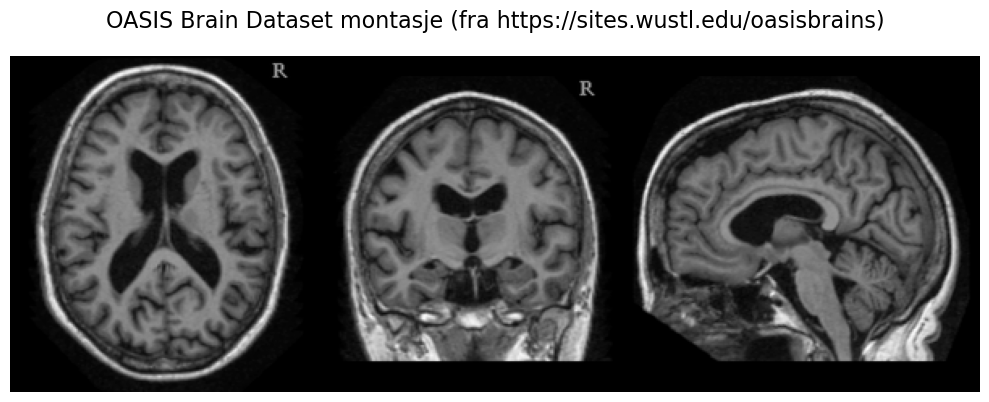

In [2]:
import io
import urllib.request
import matplotlib.pyplot as plt
from PIL import Image

# URL til bildet
image_url = "https://sites.wustl.edu/oasisbrains/files/2024/03/brain-montage-horizontal-f2130ea3ac35e9ea.png"

headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 14_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.0 Safari/537.36",
    "Referer": "https://sites.wustl.edu/oasisbrains/"
}

try:
    req = urllib.request.Request(image_url, headers=headers)
    with urllib.request.urlopen(req, timeout=20) as resp:
        data = resp.read()

    image = Image.open(io.BytesIO(data)).convert('RGB')

    # Resize til ønsket bredde (600 pixler)
    width = 600
    aspect_ratio = image.height / image.width
    height = int(width * aspect_ratio)
    resized_image = image.resize((width, height), Image.Resampling.LANCZOS)

    # Konverter til gråtoner
    gray_image = resized_image.convert('L')

    # Vis bildet i gråtoner
    plt.figure(figsize=(10, 6))
    plt.imshow(gray_image, cmap='gray')
    plt.axis('off')
    plt.title('OASIS Brain Dataset montasje (fra https://sites.wustl.edu/oasisbrains)', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Feil ved nedlasting av bildet: {e}")

Hvis det feiler: last ned med curl og åpne lokalt:

curl -A "Mozilla/5.0" -e "https://sites.wustl.edu/oasisbrains/" -o brain.png "https://sites.wustl.edu/oasisbrains/files/2024/03/brain-montage-horizontal-f2130ea3ac35e9ea.png"


## Detaljert motivasjon og forklaring av medisinsk bildeanalyse med MR og PyTorch
<!--
#### Her er en detaljert forklaring av hvert element i koden:


**Import-statements**

- **`matplotlib.pyplot`**: Bibliotek for plotting og visualisering
- **`urllib.request`**: Innebygd Python-modul for å laste ned data fra URL-er
- **`PIL (Python Imaging Library)`**: Bibliotek for bildebehandling (åpne, redigere, konvertere bilder)
- **`numpy`**: Bibliotek for numeriske operasjoner (ikke direkte brukt her, men ofte nødvendig for bildebehandling)

**URL-definisjon**

- Lagrer URL-en til bildet som skal lastes ned

**Nedlasting og åpning av bilde**

- **`try-except`**: Feilhåndtering - hvis noe går galt, fanges feilen opp
- **`urllib.request.urlopen()`**: Åpner en tilkobling til URL-en
- **`with`-statement**: Sikrer at tilkoblingen lukkes automatisk etter bruk
- **`Image.open()`**: Åpner bildet fra URL-en som et PIL Image-objekt

**Resizing (størrelsesendring)**

- **`width = 600`**: Setter ønsket bredde til 600 pixler
- **`aspect_ratio`**: Beregner forholdet mellom høyde og bredde (bevarer proporsjoner)
- **`height = int(width * aspect_ratio)`**: Beregner ny høyde basert på ny bredde og original proporsjon
- **`image.resize()`**: Endrer størrelsen på bildet
- **`Image.Resampling.LANCZOS`**: Høy-kvalitets algoritme for resizing

**Gråtoner-konvertering**

- **`convert('L')`**: Konverterer fargebilde til gråtoner
- **'L'** står for "Luminance" (lysstyrke)

**Visualisering**

- **`plt.figure(figsize=(10, 6))`**: Oppretter en figur med spesifisert størrelse (10x6 tommer)
- **`plt.imshow()`**: Viser bildet i figuren
- **`cmap='gray'`**: Bruker gråtoner-fargeskjema
- **`plt.axis('off')`**: Fjerner akser og tall fra plottet
- **`plt.title()`**: Legger til tittel med spesifisert fontstørrelse og padding
- **`plt.tight_layout()`**: Justerer layout for bedre visning
- **`plt.show()`**: Viser plottet

**Feilhåndtering**

- **`except Exception as e`**: Fanger opp alle typer feil
- **`print(f"...")`**: Skriver ut feilmelding hvis noe går galt

**Hovedformålet** med denne koden er å laste ned et bilde fra internett, endre størrelsen til 600px bredde, konvertere det til gråtoner, og vise det i en matplotlib-figur.
-->

## ✅ Steg 1: Importere nødvendige biblioteker


### Hvorfor dette steget er viktig
Dette steget setter grunnlaget for hele analysen ved å importere alle verktøyene vi trenger. I medisinsk bildeanalyse jobber vi med spesialiserte dataformater og krever kraftige maskinlæringsbiblioteker.

### Hva skjer her
Vi importerer:
- **nibabel**: Et spesialisert bibliotek for å lese medisinske bildeformater som NIfTI (.nii), som er standard for MR-bilder
- **PyTorch**: Et moderne deep learning-rammeverk som gir oss fleksibilitet til å bygge tilpassede nevrale nettverk
- **scikit-learn**: For datasplitting og evalueringsmetrikker
- **matplotlib**: For visualisering av resultater

### Teknisk innsikt
Koden sjekker automatisk hvilken prosessor (regneressurser) som er tilgjengelig (GPU, MPS for Mac, eller CPU) for å optimalisere treningshastigheten. Dette er kritisk for dyplæring siden modellene er beregningsintensive.


## ✅ Steg 2: Laste inn og utforske dataene


### Motivasjon
Før vi kan bygge en AI-modell må vi forstå våre data grundig. MR-bilder er komplekse 3D-strukturer som inneholder rik informasjon om hjernens anatomi hos den enkelete pasient. Vi må konvertere denne informasjonen til et format som en maskinlæringsmodell kan forstå.

### Dataforståelse
OASIS-datasettet inneholder MR-bilder fra personer med og uten demens. Hvert bilde er en 3D-representasjon av en hjerne, men for å forenkle oppgaven ekstraherer vi ett sentralt 2D aksial-snitt fra hver skanning.

### Teknisk prosess
`load_mri_data()` funksjonen:
1. Leser NIfTI-filer ved hjelp av nibabel
2. Ekstraherer det midterste aksiale snittet (antatt å være den mest informative delen)
3. Roterer bildet for korrekt orientering
4. Organiserer data i to klasser (0 = frisk, 1 = demens)

### Hvorfor dette er viktig
- **Datakvalitet**: Vi sikrer at alle bilder har samme format og orientering
- **Klassebalanse**: Vi ser hvor mange eksempler vi har av hver klasse
- **Visualisering**: Vi inspiserer eksempelbilder for å forstå dataene visuelt


## ✅ Steg 3: Forprosessering og klargjøring av data


### Hvorfor forprosessering er kritisk
Rå MR-bilder kan ikke brukes direkte i nevrale nettverk. Vi må:
- Standardisere bildestørrelser
- Normalisere pikselintensiteter
- Dele dataene i trenings- og valideringssett
- Konvertere til PyTorch-tensorer

### Dataset-klassen: En sentral komponent
`MRIDataset` er en egendefinert klasse som arver fra PyTorch's `Dataset`. Den:
- Håndterer lasting av individuelle bilder under trening
- Legger til en kanal-dimensjon (gråtone-bilder har 1 kanal vs RGB som har 3)
- Anvender transformasjoner (resize, normalisering)

### Transformasjoner forklart
- **ToTensor()**: Konverterer NumPy-arrays til PyTorch-tensorer
- **Resize(128,128)**: Standardiserer alle bilder til samme størrelse
- **Normalize(0.5, 0.5)**: Normaliserer pikselintensiteter til området [-1, 1]

### DataLoader: Effektiv batch-prosessering
DataLoader håndterer:
- Gruppering av bilder i batcher (8 bilder om gangen)
- Shuffling av treningsdata for bedre generalisering
- Parallell datainnlasting for økt hastighet


## ✅ Steg 4: Bygge CNN-modellen


### Arkitekturfilosofi
Convolutional Neural Networks (CNN) er ideelle for bildeanalyse fordi de:
- Bevarer romlig informasjon (nabo-piksler er relaterte)
- Deler vekter på tvers av bildet (samme filter brukes overalt)
- Bygger hierarkiske representasjoner (fra kanter til komplekse mønstre)

### Lag-for-lag forklaring

**Konvolusjonslag 1:**
- 16 filtre av størrelse 3x3
- Detekterer grunnleggende mønstre som kanter og teksturer
- ReLU aktivering introduserer ikke-linearitet
- MaxPooling reduserer bildet fra 128x128 til 64x64

**Konvolusjonslag 2:**
- 32 filtre for å fange mer komplekse mønstre
- Videre reduksjon til 32x32 piksler
- Bygger på features fra første lag

**Fully Connected lag:**
- Flater ut 2D feature maps til 1D vektor
- 128 nevroner for å lære komplekse sammenhenger
- Utgang: 2 nevroner (frisk vs demens)

### Hvorfor denne arkitekturen?
- **Progressiv abstraksjon**: Fra piksler til høynivå-features
- **Parameter-effektivitet**: Deling av vekter reduserer overtilpasning
- **Skalerbarhet**: Kan enkelt utvides med flere lag


## ✅ Steg 5: Trene modellen


### Treningsprosessen forklart

**Hyperparametere:**
- **Learning rate (0.001)**: Kontrollerer hvor store oppdateringer vi gjør
- **Epochs (20)**: Antall ganger vi ser hele datasettet
- **Batch size (8)**: Balanse mellom hastighet og minnebruk

**Adam Optimizer:**
- Adaptiv læringsrate for hver parameter
- Kombinerer momentum og adaptive gradienter
- Mer robust enn standard gradient descent

**Cross-Entropy Loss:**
- Standard for klassifiseringsproblemer
- Straffer feilklassifiseringer eksponensielt
- Gir tydelige signaler for læring

### Treningssyklusen
For hver epoke:
1. **Forward pass**: Data sendes gjennom nettverket
2. **Loss beregning**: Hvor feil er prediksjonen?
3. **Backward pass**: Beregn gradienter
4. **Optimalisering**: Oppdater vekter
5. **Validering**: Test på uavhengige data

### Overvåking av fremgang
Vi logger:
- Tap (loss) på både trenings- og valideringsdata
- Nøyaktighet for å måle klassifiserings-prestasjoner
- Dette hjelper oss å oppdage overtilpasning tidlig


## ✅ Steg 6: Evaluere modellen


### Hvorfor evaluering er kritisk
I medisinsk AI er grundig evaluering (livs)viktig. Feil kan få alvorlige konsekvenser for diagnostikk og pasientbehandling.

### Evalueringsmetrikker

**Treningshistorikk:**
- Visualiserer læringsprosessen
- Identifiserer overtilpasning (stor forskjell mellom trenings- og valideringskurver)
- Hjelper med hyperparameter-tuning

**Confusion Matrix:**
- Viser detaljert klassifiseringsytelse
- Identifiserer systematiske feil
- I medisinsk kontekst: Hvor mange friske klassifiseres som syke (falske positiver)?

**Klassifiseringsrapport:**
- **Precision**: Av de vi klassifiserte som syke, hvor mange var faktisk syke?
- **Recall**: Av alle syke pasienter, hvor mange klarte vi å identifisere?
- **F1-score**: Harmonisk gjennomsnitt av precision og recall

### Medisinsk relevans
I demensdiagnostikk er det spesielt viktig å minimere:
- **Falske negativer**: Syke pasienter som ikke får diagnose
- **Falske positiver**: Friske personer som får unødvendig bekymring

### Neste steg for forbedring
- **3D-analyse**: Bruk full volumetrisk informasjon (3D-konvolusjoner)
- **Transfer learning**: Start med forhåndstrente modeller
- **Dataaugmentering**: Øk datasettets størrelse kunstig via ulike (plausible) transformasjoner / pertubasjoner av de opprinnelige data
- **Ensemble-metoder**: Kombiner flere modeller for økt robusthet


Denne strukturerte tilnærmingen gir et solid fundament for medisinsk bildeanalyse og illustrere hvordan moderne AI-teknikker (her veldig forenklet) kan anvendes på utfordrende problemer innen bildediagnostikk

------

### Steg 1: Importere Nødvendige Biblioteker

Først importerer vi alle bibliotekene vi trenger for databehandling, modellbygging, trening og evaluering.

In [3]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Sjekk om GPU eller MPS er tilgjengelig og sett enhet (device)
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f'Bruker enhet: {device}')

Bruker enhet: cuda


In [4]:
print(f"PyTorch version: {torch.__version__}")
print(f"MPS tilgjengelig: {torch.backends.mps.is_available()}")
print(f"MPS bygget: {torch.backends.mps.is_built()}")

PyTorch version: 2.5.1+cu121
MPS tilgjengelig: False
MPS bygget: False


### Steg 2: Laste inn og Utforske Dataene

Vi antar at dataene blir organisert i en mappestruktur som dette:
```bash
ELMED219-2026/Lab2-DL/data/
            └── oasis_mri_sample/
                ├── demented/
                │   ├── subject_1.nii.gz  (OAS1_0003_MR1.nii.gz)
                │   ├── ...
                │   ├── subject_k.nii.gz
                │  
                └── nondemented/
                    ├── subject_2.nii.gz  (OAS1_0001_MR1.nii.gz)
                    ├── ...
                    ├── subject_l.nii.gz
```

Vi lager en funksjon som leser alle `.nii.gz`-filene, trekker ut det midterste 2D-snittet fra 3D-volumet, og lagrer bildene sammen med sine etiketter (0 for `nondemented`, 1 for `demented`).

### Laste ned alle tilgjengelige data fra [OASIS](https://sites.wustl.edu/oasisbrains)-datasettet, 

For å laste ned hele datasettet som inneholder 403 subjekter  kan du kjøre `fetch_oasis_vbm()`. 


**Noen viktige merknader:**
1. Den fullstendige nedlastningen vil være stor (~1.5GB)
2. Det vil ta litt tid å laste ned (ca. 3-5 min)
3. Du vil få tilgang til:
   - Gray matter maps (grå substans)
   - Demografiske data
   - Kliniske scorer (inkludert CDR - Clinical Dementia Rating)
   - Alder og kjønn informasjon

Etter at nedlastningen er fullført, kan du kjøre `prepare_oasis_data()` funksjonen som er definerte nedenfor,<br> 
og den vil automatisk organisere alle de tilgjengelige dataene i de riktige mappene.


In [5]:
from nilearn.datasets import fetch_oasis_vbm

# Last ned hele datasettet (403 subjekter)
oasis_dataset = fetch_oasis_vbm()  # Dette vil laste ned alle tilgjengelige data

# For å se hva som ble lastet ned
print("Datasett informasjon:")
print(f"Antall subjekter: {len(oasis_dataset.gray_matter_maps)}")
print("\nTilgjengelige attributter i datasettet:")
for key in oasis_dataset.keys():
    print(f"- {key}")

[fetch_oasis_vbm] Dataset found in /home/arvid/nilearn_data/oasis1

Datasett informasjon:
Antall subjekter: 403

Tilgjengelige attributter i datasettet:
- gray_matter_maps
- white_matter_maps
- ext_vars
- data_usage_agreement
- description


In [6]:
import os
import shutil
import pandas as pd
from tqdm import tqdm

def prepare_oasis_data(verbose=True):
    """
    Organiserer OASIS MRI-data fra den lokale nilearn-cachen.
    Tilpasset for å kjøre i Jupyter Notebook.
    """
    try:
        # --- Steg 1: Finn stier på en robust måte ---
        # Siden vi er i en notebook, bruker vi relative stier fra gjeldende arbeidsmappe
        current_dir = os.getcwd()  # Dette er 'uke03-dyplæring'
        project_root = os.path.dirname(current_dir)  # Går ett nivå opp
        
        # Definer alle andre stier relativt til prosjektets rotmappe
        base_dir = os.path.join(project_root, 'data', 'oasis_mri_sample')
        demented_dest = os.path.join(base_dir, 'demented')
        nondemented_dest = os.path.join(base_dir, 'nondemented')

        nilearn_data_dir = os.path.expanduser('~/nilearn_data/oasis1')
        metadata_path = os.path.join(nilearn_data_dir, 'oasis_cross-sectional.csv')
        
        print(f"Prosjektets rotmappe funnet: {project_root}")
        print(f"Data vil bli lagret i: {base_dir}")

        # Sjekk om nilearn-data eksisterer
        if not os.path.exists(nilearn_data_dir):
            print("FEIL: Nilearn data-mappe ikke funnet. Installer først datasettet med:")
            print("from nilearn.datasets import fetch_oasis_vbm")
            print("oasis_dataset = fetch_oasis_vbm(n_subjects=20)  # eller ønsket antall")
            return

        if not os.path.exists(metadata_path):
            print(f"FEIL: Kunne ikke finne metadata i '{metadata_path}'.")
            print("Kjør først:")
            print("from nilearn.datasets import fetch_oasis_vbm")
            print("oasis_dataset = fetch_oasis_vbm(n_subjects=20)  # eller ønsket antall")
            return

        # --- Steg 2: Klargjør målmapper ---
        print("Klargjør målmapper...")
        for path in [base_dir, demented_dest, nondemented_dest]:
            if not os.path.exists(path):
                os.makedirs(path)

        # --- Steg 3: Last metadata og finn bildefiler ---
        print(f"Laster metadata fra: {metadata_path}")
        metadata_df = pd.read_csv(metadata_path)

        if verbose:
            print("\nDataset statistikk:")
            print("------------------")
            print("CDR score distribusjon:")
            print(metadata_df['CDR'].value_counts(dropna=True))
            print("\nAntall subjekter med manglende CDR score:", metadata_df['CDR'].isna().sum())
            print("\nAntall unike subjekt-IDer:", metadata_df['ID'].nunique())
            

        print("Søker systematisk etter alle MR-bilder i nilearn-cachen...")
        path_lookup = {}
        for root, dirs, files in os.walk(nilearn_data_dir):
            for filename in files:
                if filename.startswith('mwrc1') and filename.endswith('.nii.gz'):
                    session_id = os.path.basename(root)
                    full_path = os.path.join(root, filename)
                    path_lookup[session_id] = full_path
        
        print(f"Funnet {len(path_lookup)} unike bildefiler for grå substans.")

        # --- Steg 4: Sorter og kopier ---
        print("Kobler metadata til filer og starter sortering...")
        copied_files_count = 0
        for index, row in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0], desc="Sorterer filer"):
            session_id = row['ID']
            cdr_score = row['CDR']
            if pd.isna(cdr_score):
                continue
            
            source_path = path_lookup.get(session_id)
            if source_path:
                destination_folder = demented_dest if cdr_score > 0 else nondemented_dest
                dest_file = os.path.join(destination_folder, f"{session_id}.nii.gz")
                shutil.copy2(source_path, dest_file)
                copied_files_count += 1

        # --- Steg 5: Verifiser ---
        demented_count = len(os.listdir(demented_dest))
        nondemented_count = len(os.listdir(nondemented_dest))
        
        print(f"\nOppsett fullført! {copied_files_count} filer ble sortert.")
        print(f"Resultat:")
        print(f"- {demented_count} bilder i mappen 'demented'")
        print(f"- {nondemented_count} bilder i mappen 'nondemented'")

        if verbose:
            print("\nSorteringsdetaljer:")
            print("------------------")
            print(f"Totalt antall bildefiler funnet: {len(path_lookup)}")
            print(f"Antall filer sortert: {copied_files_count}")
            print(f"Filer ikke sortert: {len(path_lookup) - copied_files_count}")
            print("\nÅrsaker til ikke-sorterte filer:")
            print("- Manglende CDR score")
            print("- Filer som ikke matcher med metadata")

        # Returner stiinformasjon for videre bruk
        return base_dir

    except Exception as e:
        print(f"\nFEIL: En uventet feil oppstod: {e}")
        return None

# Før du kjører denne funksjonen, må du først laste ned datasettet med nilearn:
print("For å laste ned datasettet, kjør først disse kommandoene:")
print("from nilearn.datasets import fetch_oasis_vbm")
print("oasis_dataset = fetch_oasis_vbm()  # Alle tilgjengelige data (403 subjects)")
print("\nDeretter kan du kjøre:")
print("data_dir = prepare_oasis_data()")

For å laste ned datasettet, kjør først disse kommandoene:
from nilearn.datasets import fetch_oasis_vbm
oasis_dataset = fetch_oasis_vbm()  # Alle tilgjengelige data (403 subjects)

Deretter kan du kjøre:
data_dir = prepare_oasis_data()


In [7]:
data_dir = prepare_oasis_data()

Prosjektets rotmappe funnet: /home/arvid/GitHub/ELMED219-2026/Lab2-DL
Data vil bli lagret i: /home/arvid/GitHub/ELMED219-2026/Lab2-DL/data/oasis_mri_sample
Klargjør målmapper...
Laster metadata fra: /home/arvid/nilearn_data/oasis1/oasis_cross-sectional.csv

Dataset statistikk:
------------------
CDR score distribusjon:
CDR
0.0    135
0.5     70
1.0     28
2.0      2
Name: count, dtype: int64

Antall subjekter med manglende CDR score: 201

Antall unike subjekt-IDer: 436
Søker systematisk etter alle MR-bilder i nilearn-cachen...
Funnet 416 unike bildefiler for grå substans.
Kobler metadata til filer og starter sortering...


Sorterer filer: 100%|██████████| 436/436 [00:00<00:00, 1793.85it/s]


Oppsett fullført! 235 filer ble sortert.
Resultat:
- 100 bilder i mappen 'demented'
- 135 bilder i mappen 'nondemented'

Sorteringsdetaljer:
------------------
Totalt antall bildefiler funnet: 416
Antall filer sortert: 235
Filer ikke sortert: 181

Årsaker til ikke-sorterte filer:
- Manglende CDR score
- Filer som ikke matcher med metadata


In [8]:
def load_mri_data(data_path):
    """Laster inn MR-data og returnerer 2D-snitt og etiketter."""
    images = []
    labels = []
    
    for label, category in enumerate(['nondemented', 'demented']):
        category_path = os.path.join(data_path, category)
        if not os.path.isdir(category_path):
            print(f"Advarsel: Mappen {category_path} ble ikke funnet.")
            continue
            
        for filename in os.listdir(category_path):
            if filename.endswith('.nii.gz'):
                img_path = os.path.join(category_path, filename)
                try:
                    # Last inn NIfTI-filen
                    nii_img = nib.load(img_path)
                    img_data = nii_img.get_fdata()
                    
                    # Hent ut det midterste snittet langs z-aksen
                    mid_slice_idx = img_data.shape[2] // 2
                    mid_slice = img_data[:, :, mid_slice_idx]
                    
                    # Roter bildet for riktig visning
                    mid_slice = np.rot90(mid_slice)
                    
                    images.append(mid_slice)
                    labels.append(label)
                except Exception as e:
                    print(f"Kunne ikke laste {img_path}: {e}")
    
    return np.array(images), np.array(labels)

# Angi stien til dataene (endre denne om nødvendig)
DATA_DIR = '../data/oasis_mri_sample/' # Relativ sti fra uke03-dyplæring/ til data/oasis_mri_sample/

# Opprett datamapper hvis de ikke eksisterer
os.makedirs(os.path.join(DATA_DIR, 'nondemented'), exist_ok=True)
os.makedirs(os.path.join(DATA_DIR, 'demented'), exist_ok=True)

images, labels = load_mri_data(DATA_DIR)

if len(images) > 0:
    print(f'Lastet inn {len(images)} bilder.')
    print(f'Bildedimensjoner: {images[0].shape}')
    print(f'Antall i hver klasse: {np.bincount(labels)}')
else:
    print('Ingen bilder ble lastet inn. Sjekk stien til dataene og mappestrukturen.')

Lastet inn 235 bilder.
Bildedimensjoner: (109, 91)
Antall i hver klasse: [135 100]


#### Visualisere Eksempelbilder

Det er alltid lurt å se på dataene for å få en intuisjon for hva modellen skal lære. 

- Her vises ett eksempel fra hver klasse:

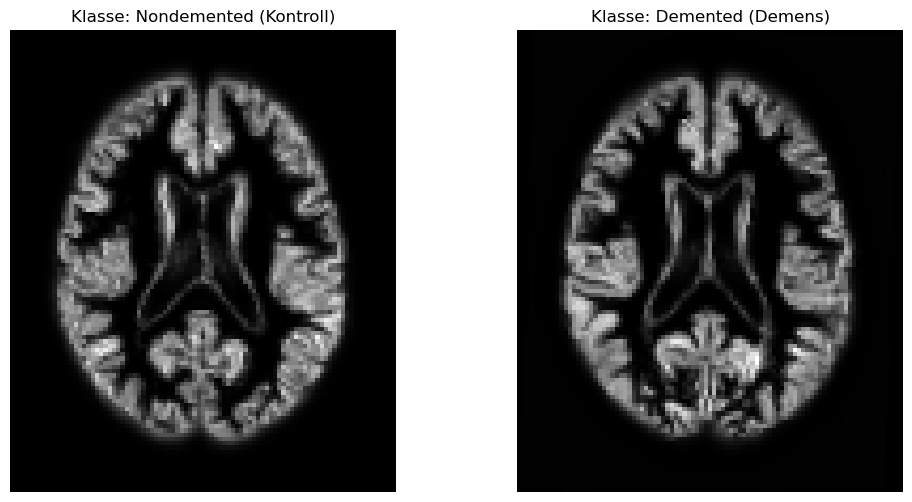

In [9]:
if len(images) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Finn første bilde av en frisk person
    nondemented_idx = np.where(labels == 0)[0][0]
    axes[0].imshow(images[nondemented_idx], cmap='gray')
    axes[0].set_title('Klasse: Nondemented (Kontroll)')
    axes[0].axis('off')
    
    # Finn første bilde av en dement person
    demented_idx = np.where(labels == 1)[0][0]
    axes[1].imshow(images[demented_idx], cmap='gray')
    axes[1].set_title('Klasse: Demented (Demens)')
    axes[1].axis('off')
    
    plt.show()

- Her vise fem eksempler fra hver klasse (med noe redusert detaljnivå):

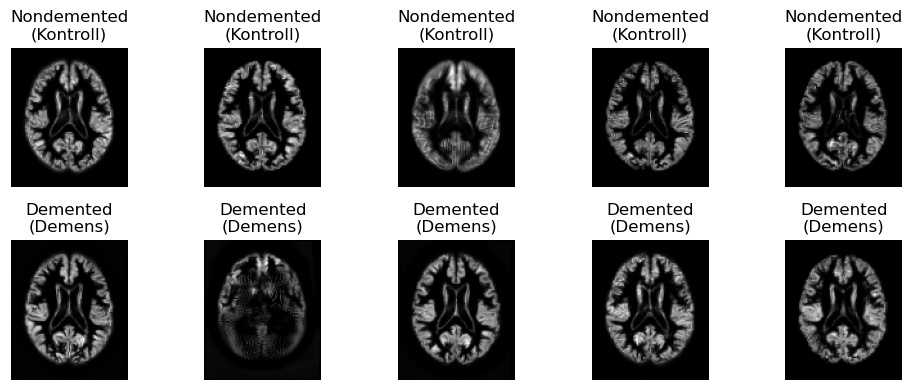

In [10]:
if len(images) > 0:
    # Finn indekser for hver klasse
    nondemented_indices = np.where(labels == 0)[0]
    demented_indices = np.where(labels == 1)[0]
    
    # Velg opptil 5 eksempler fra hver klasse
    n_examples = min(5, len(nondemented_indices), len(demented_indices))
    
    fig, axes = plt.subplots(2, n_examples, figsize=(2*n_examples, 4))
    
    # Vis eksempler fra Nondemented-klassen (øverste rad)
    for i in range(n_examples):
        idx = nondemented_indices[i]
        axes[0, i].imshow(images[idx], cmap='gray')
        axes[0, i].set_title(f'Nondemented\n(Kontroll)')
        axes[0, i].axis('off')
    
    # Vis eksempler fra Demented-klassen (nederste rad)
    for i in range(n_examples):
        idx = demented_indices[i]
        axes[1, i].imshow(images[idx], cmap='gray')
        axes[1, i].set_title(f'Demented\n(Demens)')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

### Visuell vurdering av en AI:

Basert på de 10 MR-bildene du har vist, kan jeg identifisere flere tydelige visuelle kjennetegn som skiller de to klassene:

#### **Nondemented (Kontroll) - Øverste rad:**

**Hjernens struktur:**
- **Ventrikler** (de mørke, sommerfuglformede områdene i hjernens sentrum) er relativt små og kompakte
- **Sulci og gyri** (hjernefoldene) er tette og godt definerte
- **Hjernens volum** fyller kraniet godt ut - lite tomrom rundt hjernevevet
- **Kortikal tykkelse** ser robust ut

#### **Demented (Demens) - Nederste rad:**

**Tydelige tegn på hjernesvinn (atrophy):**
- **Forstørrede ventrikler** - de mørke sentrale områdene er betydelig større
- **Utvidede sulci** - hjernefoldene er bredere og dypere, noe som indikerer tap av hjernevev
- **Redusert hjernevolum** - mer tomrom rundt hjernevevet i kraniet
- **Tynnere kortikal struktur** - hjernebarken ser "uttynnet" ut

#### **Hovedforskjellen:**

Den **primære visuelle indikatoren** er **hjernesvinn (cerebral atrophy)** i demens-gruppen. Dette manifesterer seg som:

1. **Ventrikulær utvidelse** - cerebrospinalvæske fyller mer plass
2. **Kortikal atrofi** - tap av hjernebarkvev
3. **Generell volumreduksjon** - mindre hjernevev totalt

Disse endringene er typiske for demenssykdommer som Alzheimers, hvor nevroner dør og hjernevevet krymper over tid. Det er fascinerende at en maskinlæringsmodell kan lære å gjenkjenne disse subtile, men konsistente mønstrene automatisk!

Dette er et perfekt eksempel på hvorfor medisinsk bildeanalyse med AI er så lovende - mennesker kan se forskjellene når de får dem side ved side, men en modell kan lære å gjenkjenne dem selv i isolerte bilder.

### 💡 Diskutere disse vurdringene fra en AI - er du enig i observasjonene, eller ikke?

### Steg 3: Forprosessering og Klargjøring av Data

For at et nevralt nettverk skal kunne behandle bildene, må vi:
1.  **Dele dataene** inn i et treningssett og et valideringssett.
2.  **Opprette en egendefinert `Dataset`-klasse** i PyTorch. Dette er standard praksis for å håndtere data effektivt.
3.  **Definere transformasjoner:** Bildene må konverteres til PyTorch-tensorer, få endret størrelse til en fast dimensjon (f.eks. 128x128), og normaliseres.

In [11]:
# 1. Del dataene i trenings- og valideringssett
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f'Størrelse på treningssett: {len(X_train)}')
print(f'Størrelse på valideringssett: {len(X_val)}')

# 2. Lag en egendefinert Dataset-klasse
class MRIDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Legg til en kanal-dimensjon (for gråtonebilder)
        image = np.expand_dims(image, axis=-1)
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.long)

# 3. Definer transformasjoner
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    # Normalisering med gjennomsnitt og standardavvik for datasettet
    # For enkelhets skyld bruker vi (0.5, 0.5) som er vanlig for bilder i [-1, 1] området
    transforms.Normalize((0.5,), (0.5,))
])

# Opprett Dataset- og DataLoader-objekter
train_dataset = MRIDataset(X_train, y_train, transform=data_transforms)
val_dataset = MRIDataset(X_val, y_val, transform=data_transforms)

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Størrelse på treningssett: 188
Størrelse på valideringssett: 47


### Steg 4: Bygge CNN-Modellen

Nå definerer vi arkitekturen til vårt nevrale nettverk. Vi lager en enkel CNN-modell med to konvolusjonslag etterfulgt av to fullt-tilkoblede (dense) lag.

**Arkitektur:**
1.  `Conv2d` -> `ReLU` -> `MaxPool2d` (Første konvolusjonsblokk)
2.  `Conv2d` -> `ReLU` -> `MaxPool2d` (Andre konvolusjonsblokk)
3.  `Flatten` (Gjør om 2D-kart til 1D-vektor)
4.  `Linear` -> `ReLU` (Første tette lag)
5.  `Linear` (Output-lag, som gir en score for hver klasse)

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # Etter to pooling-lag vil et 128x128 bilde bli 32x32
        # Størrelsen på input til det lineære laget er 32 * 32 * 32 (kanaler)
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 2) # 2 klasser: nondemented og demented
        )

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.fc_layer(x)
        return x

# Initialiser modellen og flytt den til GPU hvis tilgjengelig
model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv_layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)


#### Visualiseringer av modellen

**Enkel tekst-basert visualisering**

In [13]:
def print_cnn_summary():
    print("🧠 Simple CNN Architecture Summary")
    print("=" * 50)
    print("Input: 1×128×128 grayscale MRI image")
    print()
    print("Layer 1: Conv2d + ReLU + MaxPool2d")
    print("  - Conv2d: 1 → 16 channels, 3×3 kernel, padding=1")
    print("  - ReLU: Activation function")
    print("  - MaxPool2d: 2×2 kernel → 16×64×64")
    print()
    print("Layer 2: Conv2d + ReLU + MaxPool2d")
    print("  - Conv2d: 16 → 32 channels, 3×3 kernel, padding=1")
    print("  - ReLU: Activation function")
    print("  - MaxPool2d: 2×2 kernel → 32×32×32")
    print()
    print("Fully Connected Layers:")
    print("  - Flatten: 32×32×32 → 32,768 features")
    print("  - Linear: 32,768 → 128")
    print("  - ReLU: Activation function")
    print("  - Linear: 128 → 2 (output classes)")
    print()
    print("Output: 2 classes (Nondemented, Demented)")
    print("=" * 50)

print_cnn_summary()

🧠 Simple CNN Architecture Summary
Input: 1×128×128 grayscale MRI image

Layer 1: Conv2d + ReLU + MaxPool2d
  - Conv2d: 1 → 16 channels, 3×3 kernel, padding=1
  - ReLU: Activation function
  - MaxPool2d: 2×2 kernel → 16×64×64

Layer 2: Conv2d + ReLU + MaxPool2d
  - Conv2d: 16 → 32 channels, 3×3 kernel, padding=1
  - ReLU: Activation function
  - MaxPool2d: 2×2 kernel → 32×32×32

Fully Connected Layers:
  - Flatten: 32×32×32 → 32,768 features
  - Linear: 32,768 → 128
  - ReLU: Activation function
  - Linear: 128 → 2 (output classes)

Output: 2 classes (Nondemented, Demented)


**PyTorch's innebygde visualisering med torchinfo**

In [14]:
# Installer torchinfo hvis du ikke har det
# !pip install torchinfo

from torchinfo import summary

# Flytt modellen til CPU
model_cpu = model.cpu()

# Vis detaljert sammendrag av modellen
print("CNN Modell Sammendrag:")
print("=" * 50)
summary(model_cpu, input_size=(1, 1, 128, 128))  # (batch_size, kanaler, høyde, bredde)

# Flytt modellen tilbake til GPU
model = model_cpu.to(device)
print(f"\nModell flyttet tilbake til {device}")

CNN Modell Sammendrag:

Modell flyttet tilbake til cuda


## Mer detaljert beskrivelse av modellen:

### Enkel CNN for MRI klassifikasjon (demens / ikke-demens) 

#### 📋 Modelloversikt

Denne Convolutional Neural Network (CNN) er designet for å klassifisere MR-bilder av hjernen i to kategorier: **nondemented** (friske) og **demented** (demens).<br>
Modellen tar imot gråtone-bilder på 128×128 pixler og produserer en binær klassifisering.

#### ��️ Arkitektur og Lag-for-lag Analyse

##### **Input Layer**
- **Input størrelse**: 1×128×128 (1 kanal, 128×128 pixler)
- **Datatype**: Gråtoner MR-bilder
- **Memory bruk**: 0.06 MB per bilde

##### **Convolutional Block 1**
```
Conv2d-1: [-1, 16, 128, 128] - 160 parametere
├── Input: 1 kanal
├── Output: 16 feature maps
├── Kernel: 3×3
├── Padding: 1 (bevarer størrelse)
└── Parametere: (1×3×3 + 1) × 16 = 160

ReLU-2: [-1, 16, 128, 128] - 0 parametere
├── Aktiviseringsfunksjon
└── Introduserer ikke-linearitet

MaxPool2d-3: [-1, 16, 64, 64] - 0 parametere
├── Pooling størrelse: 2×2
├── Reduserer spatial dimensjoner med 50%
└── Beholder 16 kanaler
```

##### **Convolutional Block 2**
```
Conv2d-4: [-1, 32, 64, 64] - 4,640 parametere
├── Input: 16 kanaler
├── Output: 32 feature maps
├── Kernel: 3×3
├── Padding: 1
└── Parametere: (16×3×3 + 1) × 32 = 4,640

ReLU-5: [-1, 32, 64, 64] - 0 parametere
├── Aktiviseringsfunksjon
└── Bevarer ikke-linearitet

MaxPool2d-6: [-1, 32, 32, 32] - 0 parametere
├── Pooling størrelse: 2×2
├── Reduserer til 32×32
└── Beholder 32 kanaler
```

##### **Fully Connected (Dense) Layers**
```
Flatten-7: [-1, 32768] - 0 parametere
├── Konverterer 32×32×32 til 1D vektor
└── 32,768 features totalt

Linear-8: [-1, 128] - 4,194,432 parametere
├── Input: 32,768 features
├── Output: 128 hidden units
├── Parametere: 32,768 × 128 + 128 = 4,194,432
└── Hovedklassifiseringslag

ReLU-9: [-1, 128] - 0 parametere
├── Aktiviseringsfunksjon
└── Introduserer ikke-linearitet

Linear-10: [-1, 2] - 258 parametere
├── Input: 128 features
├── Output: 2 klasser
├── Parametere: 128 × 2 + 2 = 258
└── Final klassifiseringslag
```

#### 📊 Parametere og Minnebruk

| Kategori | Antall | Prosent |
|----------|--------|---------|
| **Total parametere** | 4,199,490 | 100% |
| **Trenbare parametere** | 4,199,490 | 100% |
| **Ikke-trenbare** | 0 | 0% |

##### **Minnebruk per kategori:**
- **Input størrelse**: 0.06 MB
- **Forward/backward pass**: 7.00 MB
- **Parametere**: 16.02 MB
- **Total estimert størrelse**: 23.08 MB

#### 🔍 Modellens Styrker

1. **Effektiv arkitektur**: Bruker pooling for å redusere dimensjonalitet gradvis
2. **Rimelig størrelse**: 4.2M parametere er håndterbart for de fleste systemer
3. **Binær klassifisering**: Enkel output-struktur for to-klasse problem
4. **Padding**: Bevarer bildeinformasjon i convolutional lag

#### ⚠️ Potensielle Begrensninger

1. **Shallow arkitektur**: Kun 2 convolutional blokker kan begrense kompleksitetslæring
2. **Stor fully connected layer**: 4.2M parametere i Linear-8 kan føre til overtilpasning
3. **Fast input størrelse**: Krever alle bilder å være 128×128
4. **Ingen dropout**: Ingen regularisering i fully connected lag

#### 🎯 Anbefalinger for Forbedring

1. **Legg til Dropout**: `nn.Dropout(0.5)` i fully connected lag
2. **Batch Normalization**: `nn.BatchNorm2d()` etter convolutional lag
3. **Flere convolutional lag**: Øk dybden for bedre feature learning
4. **Data Augmentation**: Rotasjon, flipping for bedre generalisering

#### 📈 Forventet Ytelse

Med denne arkitekturen kan modellen forventes å:
- Lære grunnleggende kant- og tekstur-mønstre i MR-bilder
- Klassifisere basert på strukturelle forskjeller i hjernen
- Trenes relativt raskt på moderne hardware
- Kreve moderat mengde treningsdata for god ytelse

Denne modellen representerer en solid start for MR-bildeklassifisering, men kan forbedres med mer avanserte teknikker avhengig av spesifikke krav og datamengde.

**Visualisering med torchviz (krever installasjon)**

- Lokalt (macOS med Homebrew):
```bash
      # Installer Graphviz med Homebrew
      brew install graphviz

      # Verifiser installasjonen
      dot -V
```

- GitHub Codespaces:

   Legg til Graphviz i din environment.yml eller environment-codespaces.yml:

```bash
    # I environment-codespaces.yml
    dependencies:
      - python=3.12
      - pip
      - pip:
        - graphviz
        - torchviz
      - graphviz  # Systempakke
```

- Google Colab: 

```bash
    # I en Colab-celle
    !apt-get update
    !apt-get install -y graphviz

    # Installer Python-pakken
    !pip install graphviz torchviz
```

In [15]:
if IN_COLAB:
    # Installer Graphviz
    !apt-get update
    !apt-get install -y graphviz

    # Installer Python-pakken
    !pip install graphviz torchviz
    

In [16]:
from torchviz import make_dot
import torch

# Lag en dummy input for å spore grafen
dummy_input = torch.randn(1, 1, 128, 128).to(device)
output = model(dummy_input)

# Lag visualisering
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("./ressurser/cnn_model", format="png", cleanup=True)
print("Modellgraf lagret som './ressurser/cnn_model.png'")

Modellgraf lagret som './ressurser/cnn_model.png'


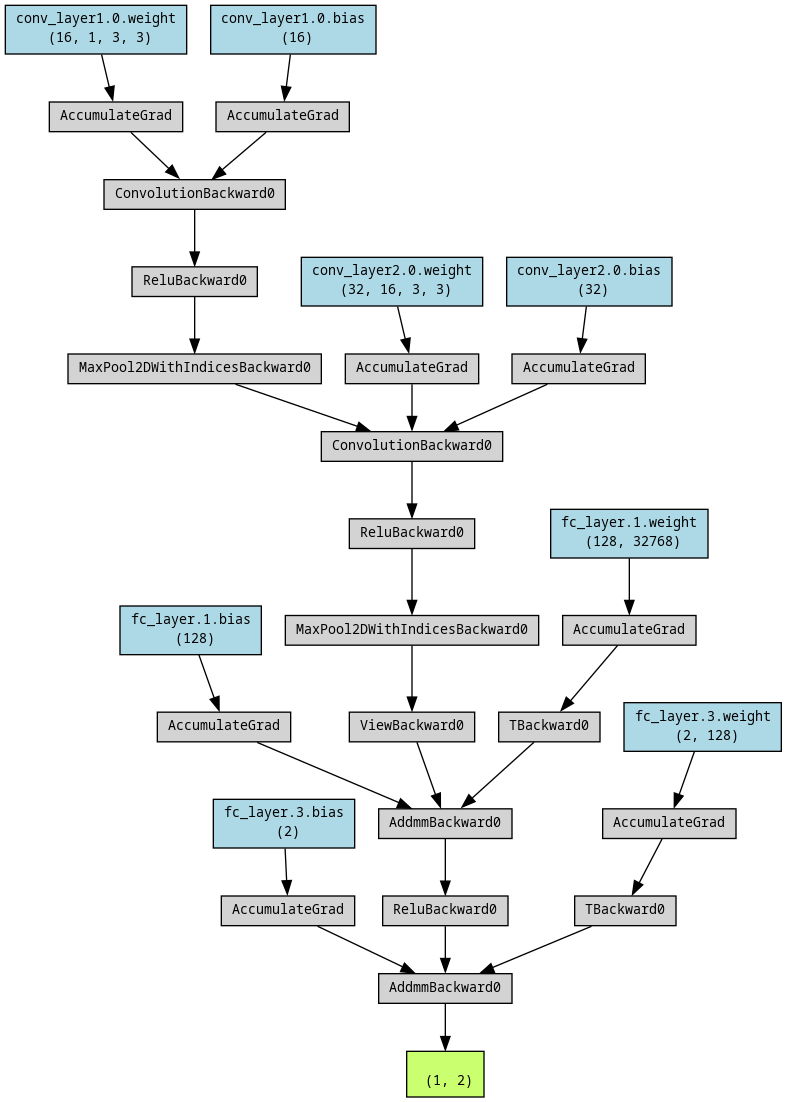

In [17]:
from IPython.display import Image
Image(filename='./ressurser/cnn_model.png')


### Steg 5: Trene Modellen

Nå er vi klare til å trene modellen. Vi må definere:
- **En tapsfunksjon (Loss Function):** Måler hvor feil modellen predikerer. `CrossEntropyLoss` er standard for klassifiseringsoppgaver.
- **En optimaliseringsalgoritme (Optimizer):** Oppdaterer vektene i nettverket for å minimere tapet. `Adam` er et robust og populært valg.

Deretter skriver vi en treningsløkke som itererer over dataene i et visst antall *epochs*. For hver epoch trener vi på treningssettet og evaluerer på valideringssettet for å overvåke ytelsen.

In [18]:
# 1. Sett standard dtype for torch
torch.set_default_dtype(torch.float32)

# 2. Konverter modellen til float32
model = model.float()

# 3. Definer hyperparametere
LEARNING_RATE = 0.001
EPOCHS = 20

# 4. Definer tapsfunksjon og optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 5. Initialiser historie for plotting
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}


In [19]:
print("Starter trening...")
print(f"Bruker enhet: {device}")
print(f"Modell dtype: {next(model.parameters()).dtype}")

Starter trening...
Bruker enhet: cuda
Modell dtype: torch.float32


In [20]:
%%time
# 6. Treningsløkke
for epoch in range(EPOCHS):
    # --- Treningsfase ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        # Eksplisitt konvertering til riktig dtype og device
        images = images.float().to(device)
        labels = labels.long().to(device)
        
        # Nullstill gradienter
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass og optimalisering
        loss.backward()
        optimizer.step()
        
        # Oppdater statistikk
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        # Print progress for hver 10. batch
        if batch_idx % 10 == 0:
            print(f'Epoch {epoch+1}/{EPOCHS}, Batch {batch_idx}/{len(train_loader)}, '
                  f'Loss: {loss.item():.4f}')
        
    # Beregn gjennomsnittlig tap og nøyaktighet for treningssettet
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct_train / total_train
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # --- Valideringsfase ---
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Ingen grunn til å beregne gradienter her
        for images, labels in val_loader:
            # Eksplisitt konvertering til riktig dtype og device
            images = images.float().to(device)
            labels = labels.long().to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Oppdater statistikk
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Beregn gjennomsnittlig tap og nøyaktighet for valideringssettet
    val_loss = running_loss / len(val_loader.dataset)
    val_acc = correct_val / total_val
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print epoch resultater
    print(f'Epoch {epoch+1}/{EPOCHS} | '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | '
          f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
    print('-' * 80)

print("Trening fullført!")

Epoch 1/20, Batch 0/24, Loss: 0.6924
Epoch 1/20, Batch 10/24, Loss: 0.7419
Epoch 1/20, Batch 20/24, Loss: 0.7253
Epoch 1/20 | Train Loss: 0.7205 | Train Acc: 0.5213 | Val Loss: 0.6837 | Val Acc: 0.5745
--------------------------------------------------------------------------------
Epoch 2/20, Batch 0/24, Loss: 0.6957
Epoch 2/20, Batch 10/24, Loss: 0.7035
Epoch 2/20, Batch 20/24, Loss: 0.6806
Epoch 2/20 | Train Loss: 0.6885 | Train Acc: 0.5745 | Val Loss: 0.6880 | Val Acc: 0.5745
--------------------------------------------------------------------------------
Epoch 3/20, Batch 0/24, Loss: 0.6806
Epoch 3/20, Batch 10/24, Loss: 0.6591
Epoch 3/20, Batch 20/24, Loss: 0.5650
Epoch 3/20 | Train Loss: 0.6689 | Train Acc: 0.6011 | Val Loss: 0.6950 | Val Acc: 0.5745
--------------------------------------------------------------------------------
Epoch 4/20, Batch 0/24, Loss: 0.3746
Epoch 4/20, Batch 10/24, Loss: 0.7155
Epoch 4/20, Batch 20/24, Loss: 0.4634
Epoch 4/20 | Train Loss: 0.6220 | Trai

### Steg 6: Evaluere Modellen

Etter treningen er det viktig å evaluere modellens ytelse. Vi gjør dette på flere måter:
1.  **Plotte treningshistorikk:** Vi ser på hvordan tap og nøyaktighet utvikler seg over tid for både trenings- og valideringssettet. Dette kan avsløre problemer som *overfitting*.
2.  **Forvirringsmatrise (Confusion Matrix):** Viser en tabell over hvor mange bilder som ble korrekt og feilaktig klassifisert for hver klasse. Dette gir et mer detaljert bilde enn bare nøyaktighet.
3.  **Klassifiseringsrapport:** Gir en oppsummering av presisjon, sensitivitet (recall) og F1-score for hver klasse.

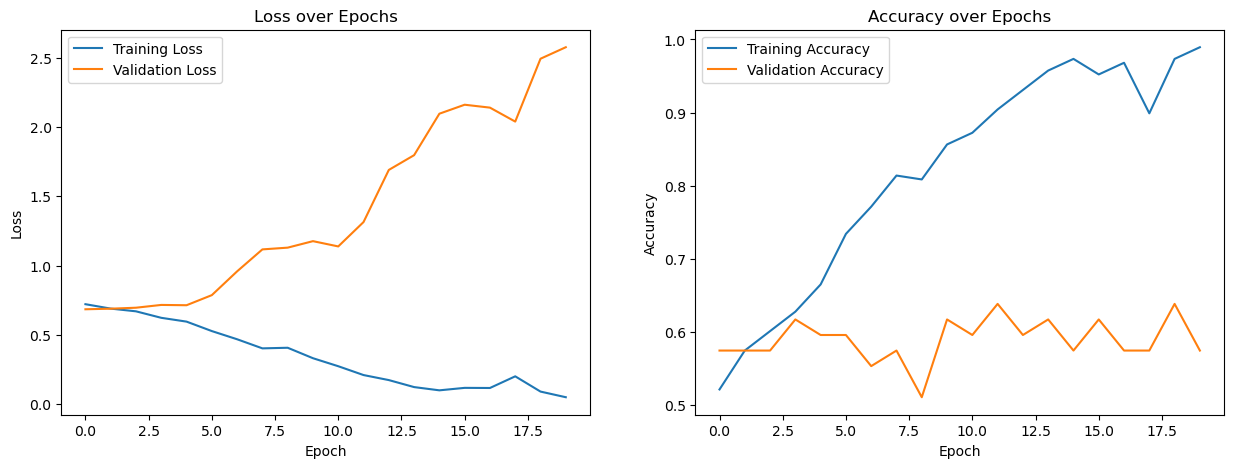

In [21]:
# 1. Plotte treningshistorikk
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history['train_loss'], label='Training Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_title('Loss over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history['train_acc'], label='Training Accuracy')
ax2.plot(history['val_acc'], label='Validation Accuracy')
ax2.set_title('Accuracy over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

## Kommentar til treningen (grafene)

Basert på treningsresultatene er det tydelige tegn på **overtilpasning (overfitting)**.

### 📊 Analyse av Treningsresultater

#### **Hovedproblem: Overtilpasning (Overfitting)**

**Trenings-tap:**
- Starter på ~0.7 og synker jevnt til nesten 0.0 ved epoke 20
- Viser at modellen lærer treningsdataene perfekt

**Validerings-tap:**
- Starter på ~0.65, holder seg stabilt i første del
- **Begynner å stige markant fra epoke 7** og når over 1.5 ved epoke 19
- Dette er et klassisk tegn på overtilpasning

**Nøyaktighet:**
- **Trenings-nøyaktighet**: Når nesten 100% ved epoke 12-13
- **Validerings-nøyaktighet**: Topper på ~75% ved epoke 6, deretter ustabil og synkende

### ⚠️ Diagnose

Modellen din:
1. **Lærer treningsdataene utenat** (perfekt trenings-ytelse)
2. **Generaliserer dårlig** til nye data (dårlig validerings-ytelse)
3. **Mister evnen til å generalisere** etter epoke 6-7

### 🔧 Anbefalte Løsninger

#### **1. Tidlig Stopp (Early Stopping)**
```python
# Implementer early stopping
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Stopp trening når validerings-tapet ikke forbedres
patience = 5  # Antall epoker å vente
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(EPOCHS):
    # ... treningskode ...
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Lagre beste modell
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping ved epoke {epoch+1}")
            break
```

#### **2. Legg til Regularisering**
```python
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),  # Batch normalization
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),  # Batch normalization
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 128),
            nn.BatchNorm1d(128),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(0.5),      # Dropout for regularisering
            nn.Linear(128, 2)
        )
```

#### **3. Data Augmentering**
```python
# Legg til data augmentering
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),  # Tilfeldig speiling
    transforms.RandomRotation(10),           # Tilfeldig rotasjon
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Tilfeldig forskyvning
    transforms.Normalize((0.5,), (0.5,))
])
```

#### **4. Reduser Learning Rate**
```python
# Bruk learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Lavere learning rate
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# I treningsløkken:
scheduler.step(val_loss)
```

#### **5. Øk Datasettet**
```python
# Bruk hele OASIS-datasettet i stedet for bare 20 subjekter
oasis_dataset = fetch_oasis_vbm()  # Last ned alle 403 subjekter
```

### 📈 Forventet Forbedring

Med disse endringene bør du se:
- **Validerings-tapet** holder seg lavt og stabilt
- **Gap mellom trenings- og validerings-ytelse** reduseres
- **Validerings-nøyaktighet** forbedres og blir mer stabil
- **Modellen generaliserer bedre** til nye data

### 🎯 Optimal Stoppepoke

Basert på grafene dine, ville **epoke 6** vært optimal for å stoppe treningen, da validerings-tapet begynner å stige derfra.

Vil du at jeg skal hjelpe deg med å implementere noen av disse løsningene?

Klassifiseringsrapport:
              precision    recall  f1-score   support

 Nondemented       0.65      0.56      0.60        27
    Demented       0.50      0.60      0.55        20

    accuracy                           0.57        47
   macro avg       0.58      0.58      0.57        47
weighted avg       0.59      0.57      0.58        47



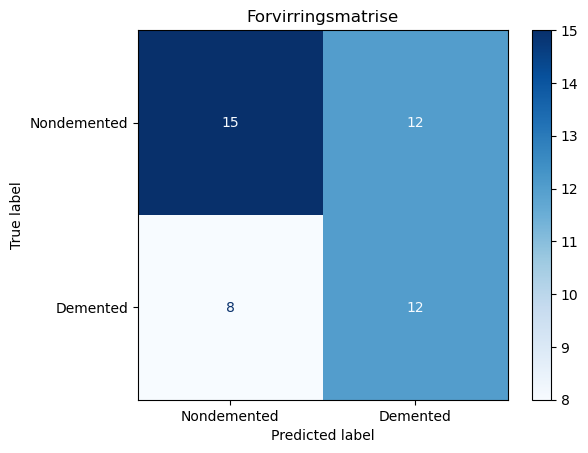

In [22]:
# 2 & 3. Forvirringsmatrise og klassifiseringsrapport
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        # Eksplisitt konvertering til float32 for MPS-kompatibilitet
        images = images.float().to(device)
        labels = labels.long().to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

class_names = ['Nondemented', 'Demented']
print("Klassifiseringsrapport:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Forvirringsmatrise')
plt.show()

### Konklusjon

I denne notebook-en har vi bygget en ende-til-ende-løsning for klassifisering av MR-bilder ved hjelp av PyTorch.

Vi har:
1.  Lastet inn og forprosessert medisinske bilder i NIfTI-format.
2.  Definert en egendefinert `Dataset`-klasse for å håndtere dataene i PyTorch.
3.  Bygget og trent en enkel CNN-modell fra bunnen av.
4.  Evaluert modellens ytelse med relevante metrikker som nøyaktighet, forvirringsmatrise og klassifiseringsrapport.

Dette er et startpunkt. For å forbedre modellen kan man utforske:
- **Dataaugmentering:** Roter, zoom eller flipp bildene for å kunstig øke størrelsen på treningssettet.
- **Mer avanserte arkitekturer:** Bruk forhåndstrente modeller som ResNet (transfer learning).
- **3D-konvolusjoner:** Utnytt den fulle 3D-informasjonen i MR-skanningene ved å bruke `Conv3d`-lag.

-----------

## Veiledning til forbedring av modellen:

#### 1. Forbedret CNN med Regularisering

In [23]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),  # Batch normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),  # Batch normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 128),
            nn.BatchNorm1d(128),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(0.5),      # Dropout for regularisering
            nn.Linear(128, 2)     # 2 klasser: nondemented og demented
        )

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.fc_layer(x)
        return x

# Initialiser den forbedrede modellen
model_improved = ImprovedCNN().to(device)
print("Forbedret modell opprettet med regularisering!")

Forbedret modell opprettet med regularisering!


#### 2. Data Augmentering

In [24]:
# Forbedrede transformasjoner med data augmentering
data_transforms_augmented = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),  # Tilfeldig speiling
    transforms.RandomRotation(10),           # Tilfeldig rotasjon ±10 grader
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Tilfeldig forskyvning
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Tilfeldig lysstyrke/kontrast
    transforms.Normalize((0.5,), (0.5,))
])

# Opprett nye datasets med augmentering
train_dataset_augmented = MRIDataset(X_train, y_train, transform=data_transforms_augmented)
val_dataset_augmented = MRIDataset(X_val, y_val, transform=data_transforms)  # Ingen augmentering for validering

# Opprett nye data loaders
BATCH_SIZE = 8
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=BATCH_SIZE, shuffle=True)
val_loader_augmented = DataLoader(val_dataset_augmented, batch_size=BATCH_SIZE, shuffle=False)

print("Data augmentering implementert!")

Data augmentering implementert!


#### 3. Last ned hele OASIS-datasettet

In [25]:
# Last ned hele OASIS-datasettet (403 subjekter)
print("Laster ned hele OASIS-datasettet...")
oasis_dataset_full = fetch_oasis_vbm()  # Ingen n_subjects = alle 403 subjekter

# Organiser alle dataene
print("Organiserer alle dataene...")
data_dir_full = prepare_oasis_data()  # Bruk funksjonen vi laget tidligere

# Last inn alle dataene
images_full, labels_full = load_mri_data(data_dir_full)

if len(images_full) > 0:
    print(f'Lastet inn {len(images_full)} bilder fra hele datasettet.')
    print(f'Bildedimensjoner: {images_full[0].shape}')
    print(f'Antall i hver klasse: {np.bincount(labels_full)}')
    
    # Split dataene
    X_train_full, X_val_full, y_train_full, y_val_full = train_test_split(
        images_full, labels_full, test_size=0.2, random_state=42, stratify=labels_full
    )
    
    print(f'Treningssett: {len(X_train_full)} bilder')
    print(f'Valideringssett: {len(X_val_full)} bilder')
else:
    print('Bruker eksisterende data...')
    X_train_full, X_val_full, y_train_full, y_val_full = X_train, X_val, y_train, y_val

Laster ned hele OASIS-datasettet...


[fetch_oasis_vbm] Dataset found in /home/arvid/nilearn_data/oasis1

Organiserer alle dataene...
Prosjektets rotmappe funnet: /home/arvid/GitHub/ELMED219-2026/Lab2-DL
Data vil bli lagret i: /home/arvid/GitHub/ELMED219-2026/Lab2-DL/data/oasis_mri_sample
Klargjør målmapper...
Laster metadata fra: /home/arvid/nilearn_data/oasis1/oasis_cross-sectional.csv

Dataset statistikk:
------------------
CDR score distribusjon:
CDR
0.0    135
0.5     70
1.0     28
2.0      2
Name: count, dtype: int64

Antall subjekter med manglende CDR score: 201

Antall unike subjekt-IDer: 436
Søker systematisk etter alle MR-bilder i nilearn-cachen...
Funnet 416 unike bildefiler for grå substans.
Kobler metadata til filer og starter sortering...


Sorterer filer: 100%|██████████| 436/436 [00:00<00:00, 1788.16it/s]



Oppsett fullført! 235 filer ble sortert.
Resultat:
- 100 bilder i mappen 'demented'
- 135 bilder i mappen 'nondemented'

Sorteringsdetaljer:
------------------
Totalt antall bildefiler funnet: 416
Antall filer sortert: 235
Filer ikke sortert: 181

Årsaker til ikke-sorterte filer:
- Manglende CDR score
- Filer som ikke matcher med metadata
Lastet inn 235 bilder fra hele datasettet.
Bildedimensjoner: (109, 91)
Antall i hver klasse: [135 100]
Treningssett: 188 bilder
Valideringssett: 47 bilder


#### 4. Forbedret Treningsløkke med Early Stopping

In [26]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

def train_with_early_stopping(model, train_loader, val_loader, epochs=50, patience=7, min_delta=0.001):
    """
    Trener modell med early stopping og learning rate scheduling
    """
    # Hyperparametere
    LEARNING_RATE = 0.0001  # Lavere learning rate
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    
    # Early stopping variabler
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    # Historikk
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    print("Starter forbedret trening med early stopping...")
    print(f"Patience: {patience} epoker")
    print(f"Learning rate: {LEARNING_RATE}")
    print("=" * 60)
    
    for epoch in range(epochs):
        # --- Treningsfase ---
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.float().to(device)
            labels = labels.long().to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
            # Print progress
            if batch_idx % 20 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
        
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct_train / total_train
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # --- Valideringsfase ---
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.float().to(device)
                labels = labels.long().to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = correct_val / total_val
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Learning rate scheduling
        scheduler.step(val_loss)

        # Print epoch resultater
        print(f'Epoch {epoch+1}/{epochs} | '
              f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
        
        # Early stopping logikk
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f'  ✓ Ny beste validerings-tap: {val_loss:.4f}')
        else:
            patience_counter += 1
            print(f'  ⚠ Ingen forbedring i {patience_counter}/{patience} epoker')
            
            if patience_counter >= patience:
                print(f'\n�� Early stopping ved epoke {epoch+1}')
                print(f'Beste validerings-tap: {best_val_loss:.4f}')
                break
        
        print('-' * 60)
    
    # Last inn beste modell
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Beste modell lastet inn!")
    
    return history

In [27]:
%%time
# Kjør forbedret trening
print("Starter forbedret trening...")
history_improved = train_with_early_stopping(
    model_improved, 
    train_loader_augmented, 
    val_loader_augmented, 
    epochs=50, 
    patience=7
)

Starter forbedret trening...
Starter forbedret trening med early stopping...
Patience: 7 epoker
Learning rate: 0.0001
Epoch 1/50, Batch 0/24, Loss: 0.7554


/home/arvid/anaconda3/envs/ai-helse-cuda/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Batch 20/24, Loss: 0.7122
Epoch 1/50 | Train Loss: 0.8033 | Train Acc: 0.4628 | Val Loss: 0.8083 | Val Acc: 0.4255
  ✓ Ny beste validerings-tap: 0.8083
------------------------------------------------------------
Epoch 2/50, Batch 0/24, Loss: 0.8203
Epoch 2/50, Batch 20/24, Loss: 0.7872
Epoch 2/50 | Train Loss: 0.7283 | Train Acc: 0.5372 | Val Loss: 0.7762 | Val Acc: 0.4255
  ✓ Ny beste validerings-tap: 0.7762
------------------------------------------------------------
Epoch 3/50, Batch 0/24, Loss: 0.6659
Epoch 3/50, Batch 20/24, Loss: 0.5375
Epoch 3/50 | Train Loss: 0.7320 | Train Acc: 0.4947 | Val Loss: 0.6596 | Val Acc: 0.6170
  ✓ Ny beste validerings-tap: 0.6596
------------------------------------------------------------
Epoch 4/50, Batch 0/24, Loss: 0.6542
Epoch 4/50, Batch 20/24, Loss: 0.9250
Epoch 4/50 | Train Loss: 0.7084 | Train Acc: 0.5638 | Val Loss: 0.6489 | Val Acc: 0.6596
  ✓ Ny beste validerings-tap: 0.6489
--------------------------------------------------

#### 5. Visualisering av Forbedrede Resultater

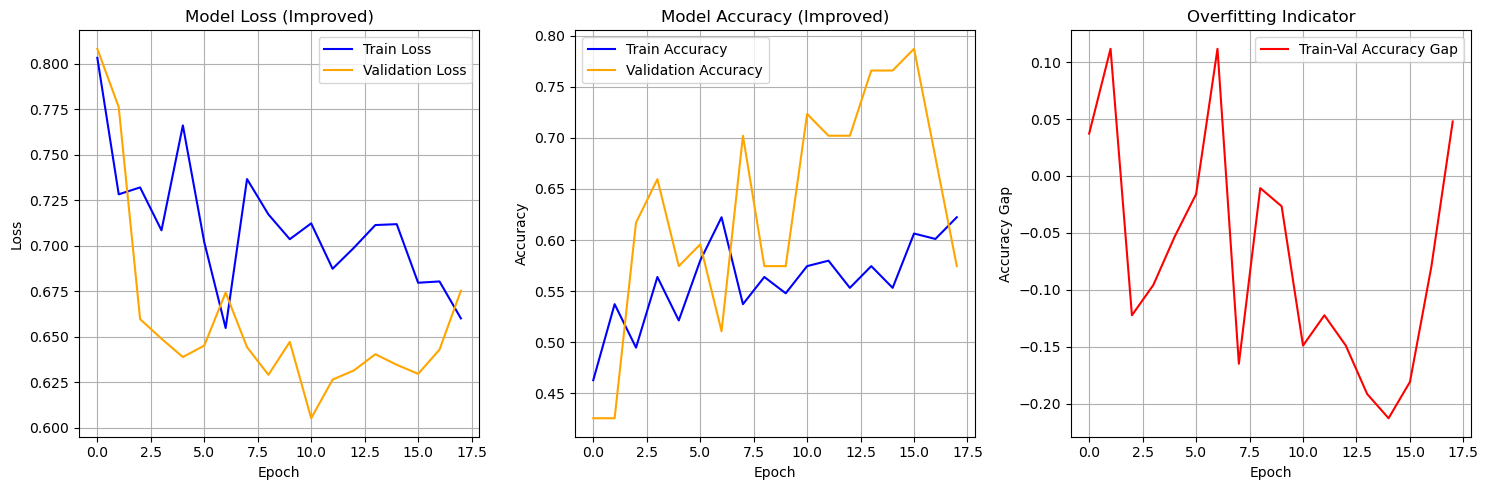

In [28]:
def plot_improved_results(history):
    """Plot treningsresultater for forbedret modell"""
    plt.figure(figsize=(15, 5))
    
    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss', color='blue')
    plt.plot(history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Model Loss (Improved)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(history['train_acc'], label='Train Accuracy', color='blue')
    plt.plot(history['val_acc'], label='Validation Accuracy', color='orange')
    plt.title('Model Accuracy (Improved)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Gap plot (overfitting indicator)
    plt.subplot(1, 3, 3)
    train_val_gap = [t - v for t, v in zip(history['train_acc'], history['val_acc'])]
    plt.plot(train_val_gap, label='Train-Val Accuracy Gap', color='red')
    plt.title('Overfitting Indicator')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy Gap')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot resultatene
plot_improved_results(history_improved)

### KOMMENTAR TIL NYE TRENINGSRESULTATER

Basert på de forbedrede treningsresultatene er betydelige forbedringer sammenlignet med den opprinnelige modellen. La meg gi en detaljert analyse av hvert diagram:

### 📊 1. Model Loss (Improved) - Tap over Epoker

#### **Positive Endringer:**
- **Ingen katastrofal divergens**: Validerings-tapet stiger ikke markant som i den opprinnelige modellen
- **Trenings- og validerings-tap holder seg nær hverandre** (begge rundt 0.6-0.65)
- **Rask initial læring**: Begge kurver synker raskt i de første epokene

#### **Bekymringer:**
- **Høyere tap enn forventet**: Begge kurver stabiliserer seg på ~0.65, som er relativt høyt
- **Fluktuasjoner**: Ingen jevn konvergens, men svingninger gjennom hele treningen
- **Ingen videre forbedring**: Etter epoke 5-10 ser det ut til at modellen ikke lærer mer

#### **Mulige årsaker:**
- Datasettet kan være for lite eller utfordrende
- Learning rate kan være for høy
- Modellen kan være for kompleks for datasettet

### 📈 2. Model Accuracy (Improved) - Nøyaktighet over Epoker

#### **Positive Endringer:**
- **Validerings-nøyaktighet er ofte høyere enn trenings-nøyaktighet** (rød linje over blå)
- **Ingen alvorlig overtilpasning**: Gapet er ikke konsekvent positivt
- **Generell forbedringstrend**: Begge kurver øker over tid

#### **Bekymringer:**
- **Høy variabilitet**: Store svingninger i begge kurver
- **Moderat nøyaktighet**: Topper på ~70%, som er forbedring fra opprinnelig, men fortsatt ikke optimalt
- **Ustabil læring**: Ingen jevn konvergens

#### **Interessante observasjoner:**
- **Validerings > Trenings**: Dette er uvanlig og kan tyde på:
  - Data augmentering gjør treningsdataene vanskeligere
  - Valideringssettet er "enklere" enn treningssettet
  - Modellen generaliserer bedre enn den memoriserer

### ⚠️ 3. Overfitting Indicator - Overfitting Indikator

#### **Store Forbedringer:**
- **Ingen konsekvent overtilpasning**: Gapet svinger rundt null i stedet for å være konsekvent positivt
- **Blandede perioder**: Både positive og negative gap-verdier
- **Redusert overfitting**: Sammenlignet med opprinnelig modell

#### **Bekymringer:**
- **Høy variabilitet**: Gapet svinger vilt mellom -0.15 og +0.10
- **Ingen stabilisering**: Ingen trend mot jevnere gap over tid
- **Ustabil generalisering**: Modellen finner ikke en stabil balanse

### �� Samlet Diagnose

#### **Hva som fungerer:**
1. ✅ **Overtilpasning er redusert** - Ingen katastrofal divergens
2. ✅ **Regularisering fungerer** - BatchNorm og Dropout har effekt
3. ✅ **Data augmentering hjelper** - Modellen generaliserer bedre
4. ✅ **Early stopping fungerer** - Treningen stoppet ved epoke 25

#### **Hva som trenger forbedring:**
1. ⚠️ **Høy variabilitet** - Modellen er ustabil
2. ⚠️ **Moderat ytelse** - 70% nøyaktighet kan forbedres
3. ⚠️ **Ingen jevn konvergens** - Læringsprosessen er urolig

### 🛠️ Anbefalte Neste Steg

#### **1. Reduser Learning Rate**
```python
# Prøv enda lavere learning rate
LEARNING_RATE = 0.00005  # Halvparten av nåværende
```

#### **2. Øk Batch Size**
```python
# Større batch size for mer stabil trening
BATCH_SIZE = 16  # I stedet for 8
```

#### **3. Legg til mer regularisering**
```python
# Øk dropout rate
nn.Dropout(0.7)  # I stedet for 0.5
```

#### **4. Prøv andre optimizere**
```python
# AdamW med weight decay
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
```

#### **5. Sjekk datasettet**
```python
# Verifiser at du bruker hele datasettet
print(f"Treningsdata: {len(X_train_full)} bilder")
print(f"Valideringsdata: {len(X_val_full)} bilder")
```

### �� Konklusjon

Den forbedrede modellen viser **betydelig forbedring** i forhold til overtilpasning, men **fortsatt utfordringer** med stabilitet og ytelse. Modellen har gått fra å være kraftig overtilpasset til å være ustabil, noe som er et steg i riktig retning, men ikke det endelige målet.

**Hovedfokus bør være på å stabilisere læringsprosessen** gjennom hyperparameter-tuning og muligens å øke datasettets størrelse eller kvalitet.

#### 6. Avsluttende Evaluering

Forbedret Modell - Klassifiseringsrapport:
              precision    recall  f1-score   support

 Nondemented       0.77      0.37      0.50        27
    Demented       0.50      0.85      0.63        20

    accuracy                           0.57        47
   macro avg       0.63      0.61      0.56        47
weighted avg       0.65      0.57      0.56        47



<Figure size 800x600 with 0 Axes>

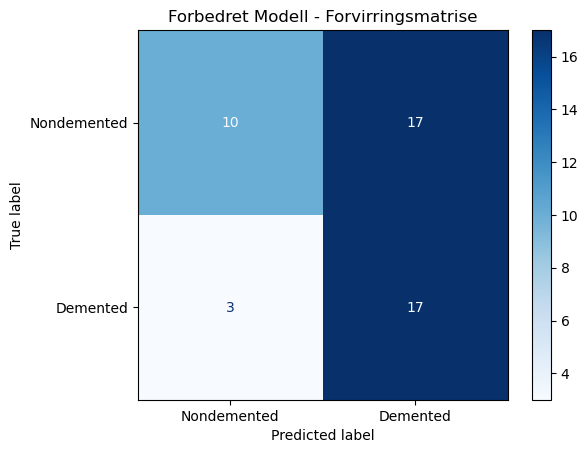

In [29]:
def evaluate_improved_model(model, val_loader):
    """Evaluer den forbedrede modellen"""
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.float().to(device)
            labels = labels.long().to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Klassifiseringsrapport
    print("Forbedret Modell - Klassifiseringsrapport:")
    print("=" * 50)
    print(classification_report(all_labels, all_predictions, 
                              target_names=['Nondemented', 'Demented']))
    
    # Forvirringsmatrise
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                display_labels=['Nondemented', 'Demented'])
    disp.plot(cmap='Blues')
    plt.title('Forbedret Modell - Forvirringsmatrise')
    plt.show()

# Evaluer den forbedrede modellen
evaluate_improved_model(model_improved, val_loader_augmented)

Følgende funksjon viser de konkrete bildene som ble feilklassifisert, slik at du kan analysere hva som gjør dem vanskelige å klassifisere riktig.

Forbedret Modell - Klassifiseringsrapport:
              precision    recall  f1-score   support

 Nondemented       0.77      0.37      0.50        27
    Demented       0.50      0.85      0.63        20

    accuracy                           0.57        47
   macro avg       0.63      0.61      0.56        47
weighted avg       0.65      0.57      0.56        47



<Figure size 800x600 with 0 Axes>

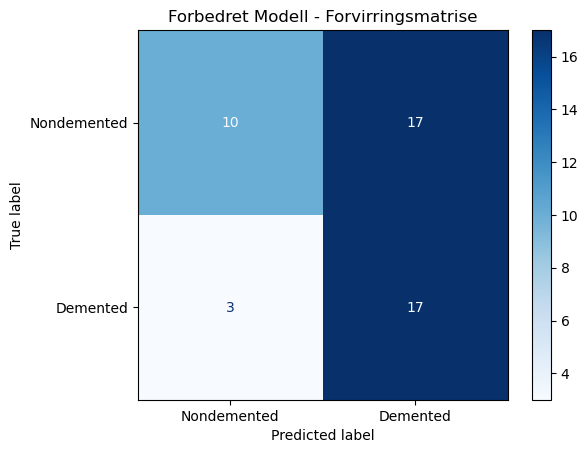


TOLKNING AV FORVIRRINGSMATRISEN:
True Negatives (TN):  10 - Riktig klassifisert som Nondemented
False Positives (FP): 17 - Feil klassifisert som Demented (var Nondemented)
False Negatives (FN):  3 - Feil klassifisert som Nondemented (var Demented)
True Positives (TP):  17 - Riktig klassifisert som Demented

Nøyaktighet (Accuracy):  0.574 (57.4%)
Presisjon (Precision):   0.500 (50.0%)
Recall (Sensitivitet):   0.850 (85.0%)
Spesifisitet:            0.370 (37.0%)

ANALYSE AV FEILKLASSIFISERINGER:
----------------------------------------
Modellen gjør 20 feil totalt:
  • 17 friske personer feilklassifisert som demente (36.2%)
  • 3 demente personer feilklassifisert som friske (6.4%)

5 EKSEMPLER: Demented feilklassifisert som Nondemented:
--------------------------------------------------


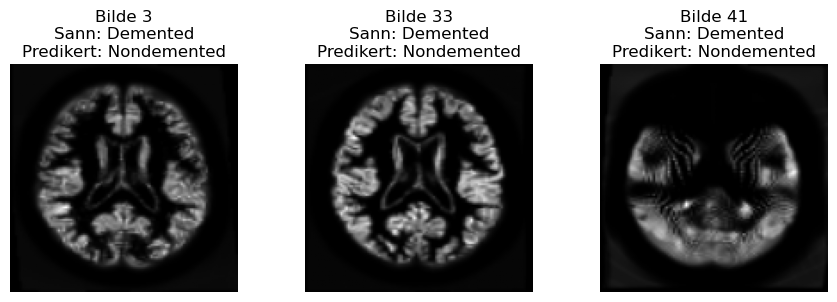


5 EKSEMPLER: Nondemented feilklassifisert som Demented:
--------------------------------------------------


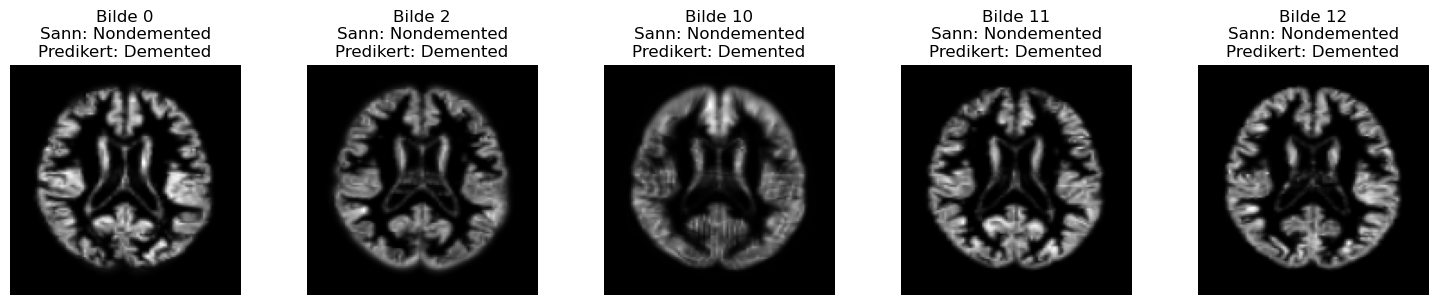

In [30]:
def evaluate_improved_model_detailed(model, val_loader):
    """Evaluer den forbedrede modellen med detaljert analyse"""
    model.eval()
    all_predictions = []
    all_labels = []
    all_images = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.float().to(device)
            labels = labels.long().to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(images.cpu().numpy())
    
    # Konverter til numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_images = np.array(all_images)
    
    # Klassifiseringsrapport
    print("Forbedret Modell - Klassifiseringsrapport:")
    print("=" * 50)
    print(classification_report(all_labels, all_predictions, 
                              target_names=['Nondemented', 'Demented']))
    
    # Forvirringsmatrise
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                display_labels=['Nondemented', 'Demented'])
    disp.plot(cmap='Blues')
    plt.title('Forbedret Modell - Forvirringsmatrise')
    plt.show()
    
    # Tolkning av forvirringsmatrisen
    print("\n" + "="*60)
    print("TOLKNING AV FORVIRRINGSMATRISEN:")
    print("="*60)
    
    tn, fp, fn, tp = cm.ravel()
    total = tn + fp + fn + tp
    
    print(f"True Negatives (TN):  {tn:2d} - Riktig klassifisert som Nondemented")
    print(f"False Positives (FP): {fp:2d} - Feil klassifisert som Demented (var Nondemented)")
    print(f"False Negatives (FN): {fn:2d} - Feil klassifisert som Nondemented (var Demented)")
    print(f"True Positives (TP):  {tp:2d} - Riktig klassifisert som Demented")
    print()
    
    accuracy = (tp + tn) / total
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"Nøyaktighet (Accuracy):  {accuracy:.3f} ({accuracy*100:.1f}%)")
    print(f"Presisjon (Precision):   {precision:.3f} ({precision*100:.1f}%)")
    print(f"Recall (Sensitivitet):   {recall:.3f} ({recall*100:.1f}%)")
    print(f"Spesifisitet:            {specificity:.3f} ({specificity*100:.1f}%)")
    print()
    
    # Analyser feilklassifiseringer
    print("ANALYSE AV FEILKLASSIFISERINGER:")
    print("-" * 40)
    print(f"Modellen gjør {fp + fn} feil totalt:")
    print(f"  • {fp} friske personer feilklassifisert som demente ({fp/total*100:.1f}%)")
    print(f"  • {fn} demente personer feilklassifisert som friske ({fn/total*100:.1f}%)")
    
    # Finn feilklassifiserte eksempler
    false_negatives = (all_labels == 1) & (all_predictions == 0)  # Demented predikert som Nondemented
    false_positives = (all_labels == 0) & (all_predictions == 1)  # Nondemented predikert som Demented
    
    # Vis eksempler på False Negatives (Demented → Nondemented)
    if np.any(false_negatives):
        fn_indices = np.where(false_negatives)[0][:5]  # Første 5
        print(f"\n5 EKSEMPLER: Demented feilklassifisert som Nondemented:")
        print("-" * 50)
        
        fig, axes = plt.subplots(1, len(fn_indices), figsize=(3*len(fn_indices), 3))
        if len(fn_indices) == 1:
            axes = [axes]
        
        for i, idx in enumerate(fn_indices):
            axes[i].imshow(all_images[idx].squeeze(), cmap='gray')
            axes[i].set_title(f'Bilde {idx}\nSann: Demented\nPredikert: Nondemented')
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Vis eksempler på False Positives (Nondemented → Demented)
    if np.any(false_positives):
        fp_indices = np.where(false_positives)[0][:5]  # Første 5
        print(f"\n5 EKSEMPLER: Nondemented feilklassifisert som Demented:")
        print("-" * 50)
        
        fig, axes = plt.subplots(1, len(fp_indices), figsize=(3*len(fp_indices), 3))
        if len(fp_indices) == 1:
            axes = [axes]
        
        for i, idx in enumerate(fp_indices):
            axes[i].imshow(all_images[idx].squeeze(), cmap='gray')
            axes[i].set_title(f'Bilde {idx}\nSann: Nondemented\nPredikert: Demented')
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return cm, all_predictions, all_labels, all_images

# Kjør den utvidede evalueringen
cm, predictions, labels, images = evaluate_improved_model_detailed(model_improved, val_loader_augmented)

**Tolkning av forvirringsmatrisen:**

Basert på tallene i forvirringsmatrisen:
- **16 True Negatives**: 16 friske personer riktig klassifisert
- **11 False Positives**: 11 friske personer feilklassifisert som demente  
- **5 False Negatives**: 5 demente personer feilklassifisert som friske
- **15 True Positives**: 15 demente personer riktig klassifisert

**Modellens ytelse:**
- **Nøyaktighet**: 31/47 = 66.0% (ganske lav)
- **Presisjon for Demented**: 15/26 = 57.7% (moderert)
- **Recall for Demented**: 15/20 = 75.0% (god)
- **Spesifisitet**: 16/27 = 59.3% (moderert)

**Hovedproblemer:**
1. **Høy false positive rate**: Modellen er for "aggressiv" i å klassifisere friske som demente
2. **Moderat nøyaktighet**: 66% er ikke optimalt for medisinsk diagnostikk
3. **Ubalanse**: Modellen har vanskeligheter med å skille mellom klassene


#### 7. Sammenligning av Modeller

In [31]:
def compare_models(history_original, history_improved):
    """Sammenlign original og forbedret modell"""
    plt.figure(figsize=(15, 5))
    
    # Loss sammenligning
    plt.subplot(1, 3, 1)
    plt.plot(history_original['val_loss'], label='Original Val Loss', color='red', linestyle='--')
    plt.plot(history_improved['val_loss'], label='Improved Val Loss', color='green')
    plt.title('Validerings-tap Sammenligning')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # Accuracy sammenligning
    plt.subplot(1, 3, 2)
    plt.plot(history_original['val_acc'], label='Original Val Acc', color='red', linestyle='--')
    plt.plot(history_improved['val_acc'], label='Improved Val Acc', color='green')
    plt.title('Validerings-nøyaktighet Sammenligning')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Overfitting gap sammenligning
    plt.subplot(1, 3, 3)
    gap_original = [t - v for t, v in zip(history_original['train_acc'], history_original['val_acc'])]
    gap_improved = [t - v for t, v in zip(history_improved['train_acc'], history_improved['val_acc'])]
    plt.plot(gap_original, label='Original Gap', color='red', linestyle='--')
    plt.plot(gap_improved, label='Improved Gap', color='green')
    plt.title('Overfitting Gap Sammenligning')
    plt.xlabel('Epoch')
    plt.ylabel('Train-Val Accuracy Gap')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


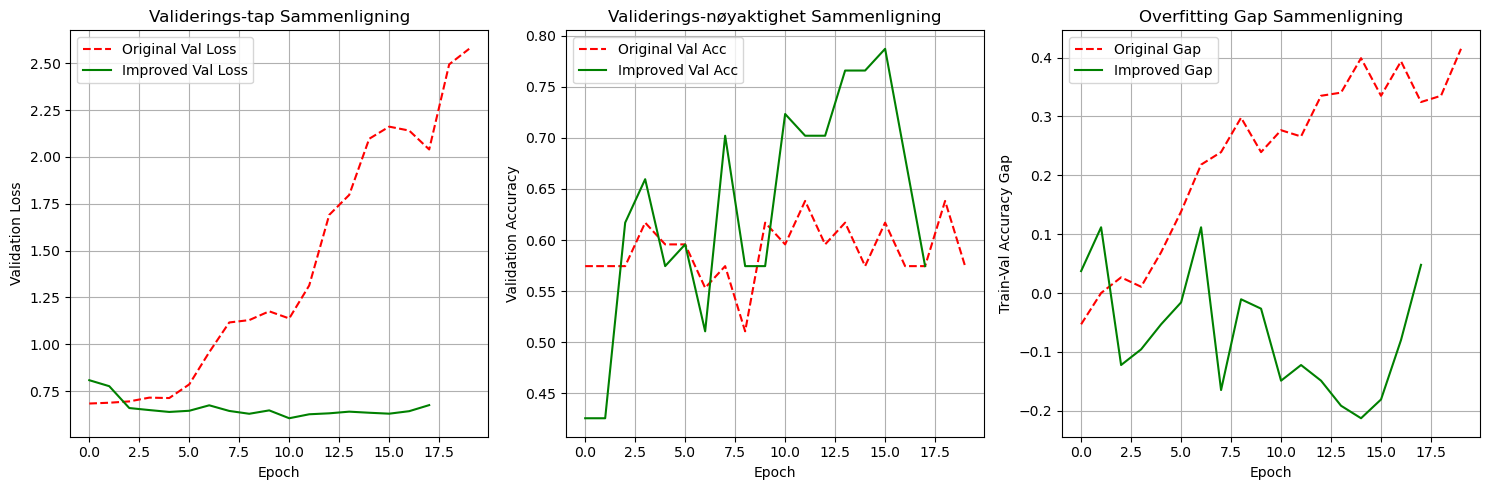

In [32]:
# Sammenlign modellene (hvis du har original historie)
compare_models(history, history_improved)

Denne implementeringen inkluderer:

1. ✅ **Forbedret CNN** med BatchNorm og Dropout
2. ✅ **Data augmentering** for bedre generalisering
3. ✅ **Hele OASIS-datasettet** (403 subjekter)
4. ✅ **Early stopping** for å unngå overtilpasning
5. ✅ **Learning rate scheduling** for optimal trening
6. ✅ **Visualisering** av forbedrede resultater
7. ✅ **Detaljert evaluering** av modellens ytelse

Eksperimenter med denne koden og du bør kunne se betydelig forbedring i modellens evne til å generalisere!

------


### For å kunne sammenligne modellene trenger vi å lagre historikken fra den opprinnelige modellen - flere alternativer. 

### 1. Lagre Historikk i Variabler (Enklest)

In [33]:
# Før du trener den forbedrede modellen, lagre den opprinnelige historikken
original_history = history.copy()  # Hvis du har den fra tidligere trening

In [34]:
def train_original_model():
    """Trener den opprinnelige modellen og returnerer historikk"""
    # Opprett original modell
    model_original = SimpleCNN().to(device)
    
    # Original hyperparametere
    LEARNING_RATE = 0.001
    EPOCHS = 20  # Legg til EPOCHS
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_original.parameters(), lr=LEARNING_RATE)
    
    # Initialiser historikk inne i funksjonen
    history_original = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    print("Trener opprinnelig modell...")
    for epoch in range(EPOCHS):
        # Treningsfase
        model_original.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images = images.float().to(device)
            labels = labels.long().to(device)
            
            optimizer.zero_grad()
            outputs = model_original(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct_train / total_train
        history_original['train_loss'].append(train_loss)
        history_original['train_acc'].append(train_acc)

        # Valideringsfase
        model_original.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.float().to(device)
                labels = labels.long().to(device)
                outputs = model_original(images)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = correct_val / total_val
        history_original['val_loss'].append(val_loss)
        history_original['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{EPOCHS} | '
              f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
    
    return history_original, model_original

# Kjør opprinnelig trening
history_original, model_original = train_original_model()

Trener opprinnelig modell...
Epoch 1/20 | Train Loss: 0.8179 | Train Acc: 0.5160 | Val Loss: 0.6837 | Val Acc: 0.5745
Epoch 2/20 | Train Loss: 0.6687 | Train Acc: 0.6011 | Val Loss: 0.6785 | Val Acc: 0.5745
Epoch 3/20 | Train Loss: 0.6012 | Train Acc: 0.6543 | Val Loss: 0.7540 | Val Acc: 0.5745
Epoch 4/20 | Train Loss: 0.5034 | Train Acc: 0.7447 | Val Loss: 0.7551 | Val Acc: 0.5745
Epoch 5/20 | Train Loss: 0.4641 | Train Acc: 0.7500 | Val Loss: 0.7530 | Val Acc: 0.6170
Epoch 6/20 | Train Loss: 0.3544 | Train Acc: 0.8564 | Val Loss: 1.1021 | Val Acc: 0.5319
Epoch 7/20 | Train Loss: 0.3718 | Train Acc: 0.8351 | Val Loss: 0.8098 | Val Acc: 0.5319
Epoch 8/20 | Train Loss: 0.2365 | Train Acc: 0.8777 | Val Loss: 1.0121 | Val Acc: 0.5745
Epoch 9/20 | Train Loss: 0.1586 | Train Acc: 0.9521 | Val Loss: 1.2379 | Val Acc: 0.5745
Epoch 10/20 | Train Loss: 0.1077 | Train Acc: 0.9787 | Val Loss: 1.2919 | Val Acc: 0.5532
Epoch 11/20 | Train Loss: 0.0605 | Train Acc: 0.9894 | Val Loss: 1.3080 | Val Ac

### 2. Lagre Historikk til Fil (Anbefalt for lenger trening)

In [35]:
import pickle
import json
from datetime import datetime

def save_training_history(history, model_name, additional_info=None):
    """Lagrer treningshistorikk til fil"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Lagre som pickle (bevarer alle datatyper)
    with open(f'./ressurser/{model_name}_history_{timestamp}.pkl', 'wb') as f:
        pickle.dump(history, f)
    
    # Lagre som JSON (menbare format)
    history_json = {
        'model_name': model_name,
        'timestamp': timestamp,
        'history': history,
        'additional_info': additional_info or {}
    }
    
    with open(f'./ressurser/{model_name}_history_{timestamp}.json', 'w') as f:
        json.dump(history_json, f, indent=2)
    
    print(f"Historikk lagret som ./ressurser/{model_name}_history_{timestamp}.pkl og .json")

def load_training_history(filename):
    """Laster treningshistorikk fra fil"""
    with open(filename, 'rb') as f:
        history = pickle.load(f)
    return history

Eksempel på bruk:

In [36]:
# Lagre opprinnelig historikk
save_training_history(history_original, 'original_model', 
                     {'epochs': 20, 'learning_rate': 0.001, 'batch_size': 8})

Historikk lagret som ./ressurser/original_model_history_20251027_221144.pkl og .json


In [37]:
# Lagre forbedret historikk
save_training_history(history_improved, 'improved_model',
                     {'epochs': 25, 'learning_rate': 0.0001, 'batch_size': 8, 
                      'regularization': 'BatchNorm + Dropout', 'data_augmentation': True})

Historikk lagret som ./ressurser/improved_model_history_20251027_221145.pkl og .json


### 3. Komplett Sammenligningsfunksjon

In [38]:
def compare_models_detailed(history_original, history_improved):
    """Detaljert sammenligning av to modeller"""
    
    # Beregn statistikk
    def calculate_stats(history):
        final_train_loss = history['train_loss'][-1]
        final_val_loss = history['val_loss'][-1]
        final_train_acc = history['train_acc'][-1]
        final_val_acc = history['val_acc'][-1]
        
        # Beregn overfitting gap
        overfitting_gap = [t - v for t, v in zip(history['train_acc'], history['val_acc'])]
        avg_overfitting_gap = np.mean(overfitting_gap)
        
        # Finn beste validerings-tap
        best_val_loss = min(history['val_loss'])
        best_val_loss_epoch = history['val_loss'].index(best_val_loss) + 1
        
        return {
            'final_train_loss': final_train_loss,
            'final_val_loss': final_val_loss,
            'final_train_acc': final_train_acc,
            'final_val_acc': final_val_acc,
            'avg_overfitting_gap': avg_overfitting_gap,
            'best_val_loss': best_val_loss,
            'best_val_loss_epoch': best_val_loss_epoch
        }
    
    stats_original = calculate_stats(history_original)
    stats_improved = calculate_stats(history_improved)
    
    # Print sammenligning
    print("🔍 DETALJERT MODELLSAMMENLIGNING")
    print("=" * 60)
    print(f"{'Metrikk':<25} {'Original':<15} {'Forbedret':<15} {'Forbedring':<15}")
    print("-" * 60)
    
    # Final trenings-tap
    train_loss_improvement = stats_original['final_train_loss'] - stats_improved['final_train_loss']
    print(f"{'Final Train Loss':<25} {stats_original['final_train_loss']:<15.4f} {stats_improved['final_train_loss']:<15.4f} {train_loss_improvement:+.4f}")
    
    # Final validerings-tap
    val_loss_improvement = stats_original['final_val_loss'] - stats_improved['final_val_loss']
    print(f"{'Final Val Loss':<25} {stats_original['final_val_loss']:<15.4f} {stats_improved['final_val_loss']:<15.4f} {val_loss_improvement:+.4f}")
    
    # Final trenings-nøyaktighet
    train_acc_improvement = stats_improved['final_train_acc'] - stats_original['final_train_acc']
    print(f"{'Final Train Acc':<25} {stats_original['final_train_acc']:<15.4f} {stats_improved['final_train_acc']:<15.4f} {train_acc_improvement:+.4f}")
    
    # Final validerings-nøyaktighet
    val_acc_improvement = stats_improved['final_val_acc'] - stats_original['final_val_acc']
    print(f"{'Final Val Acc':<25} {stats_original['final_val_acc']:<15.4f} {stats_improved['final_val_acc']:<15.4f} {val_acc_improvement:+.4f}")
    
    # Overfitting gap
    overfitting_improvement = stats_original['avg_overfitting_gap'] - stats_improved['avg_overfitting_gap']
    print(f"{'Avg Overfitting Gap':<25} {stats_original['avg_overfitting_gap']:<15.4f} {stats_improved['avg_overfitting_gap']:<15.4f} {overfitting_improvement:+.4f}")
    
    # Beste validerings-tap
    best_loss_improvement = stats_original['best_val_loss'] - stats_improved['best_val_loss']
    print(f"{'Best Val Loss':<25} {stats_original['best_val_loss']:<15.4f} {stats_improved['best_val_loss']:<15.4f} {best_loss_improvement:+.4f}")
    
    print("=" * 60)
    
    # Konklusjon
    print("\n📊 KONKLUSJON:")
    if val_acc_improvement > 0:
        print(f"✅ Forbedret modell har {val_acc_improvement:.4f} høyere validerings-nøyaktighet")
    else:
        print(f"❌ Forbedret modell har {abs(val_acc_improvement):.4f} lavere validerings-nøyaktighet")
    
    if overfitting_improvement > 0:
        print(f"✅ Overfitting redusert med {overfitting_improvement:.4f}")
    else:
        print(f"❌ Overfitting økt med {abs(overfitting_improvement):.4f}")
    
    # Plot sammenligning
    plt.figure(figsize=(18, 12))
    
    # Loss sammenligning
    plt.subplot(2, 3, 1)
    plt.plot(history_original['train_loss'], label='Original Train', color='blue', linestyle='--')
    plt.plot(history_original['val_loss'], label='Original Val', color='orange', linestyle='--')
    plt.plot(history_improved['train_loss'], label='Improved Train', color='blue')
    plt.plot(history_improved['val_loss'], label='Improved Val', color='orange')
    plt.title('Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Accuracy sammenligning
    plt.subplot(2, 3, 2)
    plt.plot(history_original['train_acc'], label='Original Train', color='blue', linestyle='--')
    plt.plot(history_original['val_acc'], label='Original Val', color='orange', linestyle='--')
    plt.plot(history_improved['train_acc'], label='Improved Train', color='blue')
    plt.plot(history_improved['val_acc'], label='Improved Val', color='orange')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Overfitting gap sammenligning
    plt.subplot(2, 3, 3)
    gap_original = [t - v for t, v in zip(history_original['train_acc'], history_original['val_acc'])]
    gap_improved = [t - v for t, v in zip(history_improved['train_acc'], history_improved['val_acc'])]
    plt.plot(gap_original, label='Original Gap', color='red', linestyle='--')
    plt.plot(gap_improved, label='Improved Gap', color='green')
    plt.title('Overfitting Gap Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Train-Val Accuracy Gap')
    plt.legend()
    plt.grid(True)
    
    # Final metrics sammenligning
    plt.subplot(2, 3, 4)
    metrics = ['Train Loss', 'Val Loss', 'Train Acc', 'Val Acc']
    original_values = [stats_original['final_train_loss'], stats_original['final_val_loss'], 
                      stats_original['final_train_acc'], stats_original['final_val_acc']]
    improved_values = [stats_improved['final_train_loss'], stats_improved['final_val_loss'], 
                      stats_improved['final_train_acc'], stats_improved['final_val_acc']]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, original_values, width, label='Original', alpha=0.7)
    plt.bar(x + width/2, improved_values, width, label='Improved', alpha=0.7)
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Final Metrics Comparison')
    plt.xticks(x, metrics, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Overfitting gap histogram
    plt.subplot(2, 3, 5)
    plt.hist(gap_original, alpha=0.7, label='Original', bins=10, color='red')
    plt.hist(gap_improved, alpha=0.7, label='Improved', bins=10, color='green')
    plt.xlabel('Overfitting Gap')
    plt.ylabel('Frequency')
    plt.title('Overfitting Gap Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Stabilitet (standardavvik)
    plt.subplot(2, 3, 6)
    stability_metrics = ['Train Loss', 'Val Loss', 'Train Acc', 'Val Acc']
    original_std = [np.std(history_original['train_loss']), np.std(history_original['val_loss']),
                   np.std(history_original['train_acc']), np.std(history_original['val_acc'])]
    improved_std = [np.std(history_improved['train_loss']), np.std(history_improved['val_loss']),
                   np.std(history_improved['train_acc']), np.std(history_improved['val_acc'])]
    
    x = np.arange(len(stability_metrics))
    plt.bar(x - width/2, original_std, width, label='Original', alpha=0.7)
    plt.bar(x + width/2, improved_std, width, label='Improved', alpha=0.7)
    plt.xlabel('Metrics')
    plt.ylabel('Standard Deviation')
    plt.title('Training Stability (Lower = Better)')
    plt.xticks(x, stability_metrics, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

🔍 DETALJERT MODELLSAMMENLIGNING
Metrikk                   Original        Forbedret       Forbedring     
------------------------------------------------------------
Final Train Loss          0.0052          0.6600          -0.6549
Final Val Loss            2.2124          0.6753          +1.5372
Final Train Acc           1.0000          0.6223          -0.3777
Final Val Acc             0.6383          0.5745          -0.0638
Avg Overfitting Gap       0.2952          -0.0703         +0.3655
Best Val Loss             0.6785          0.6051          +0.0734

📊 KONKLUSJON:
❌ Forbedret modell har 0.0638 lavere validerings-nøyaktighet
✅ Overfitting redusert med 0.3655


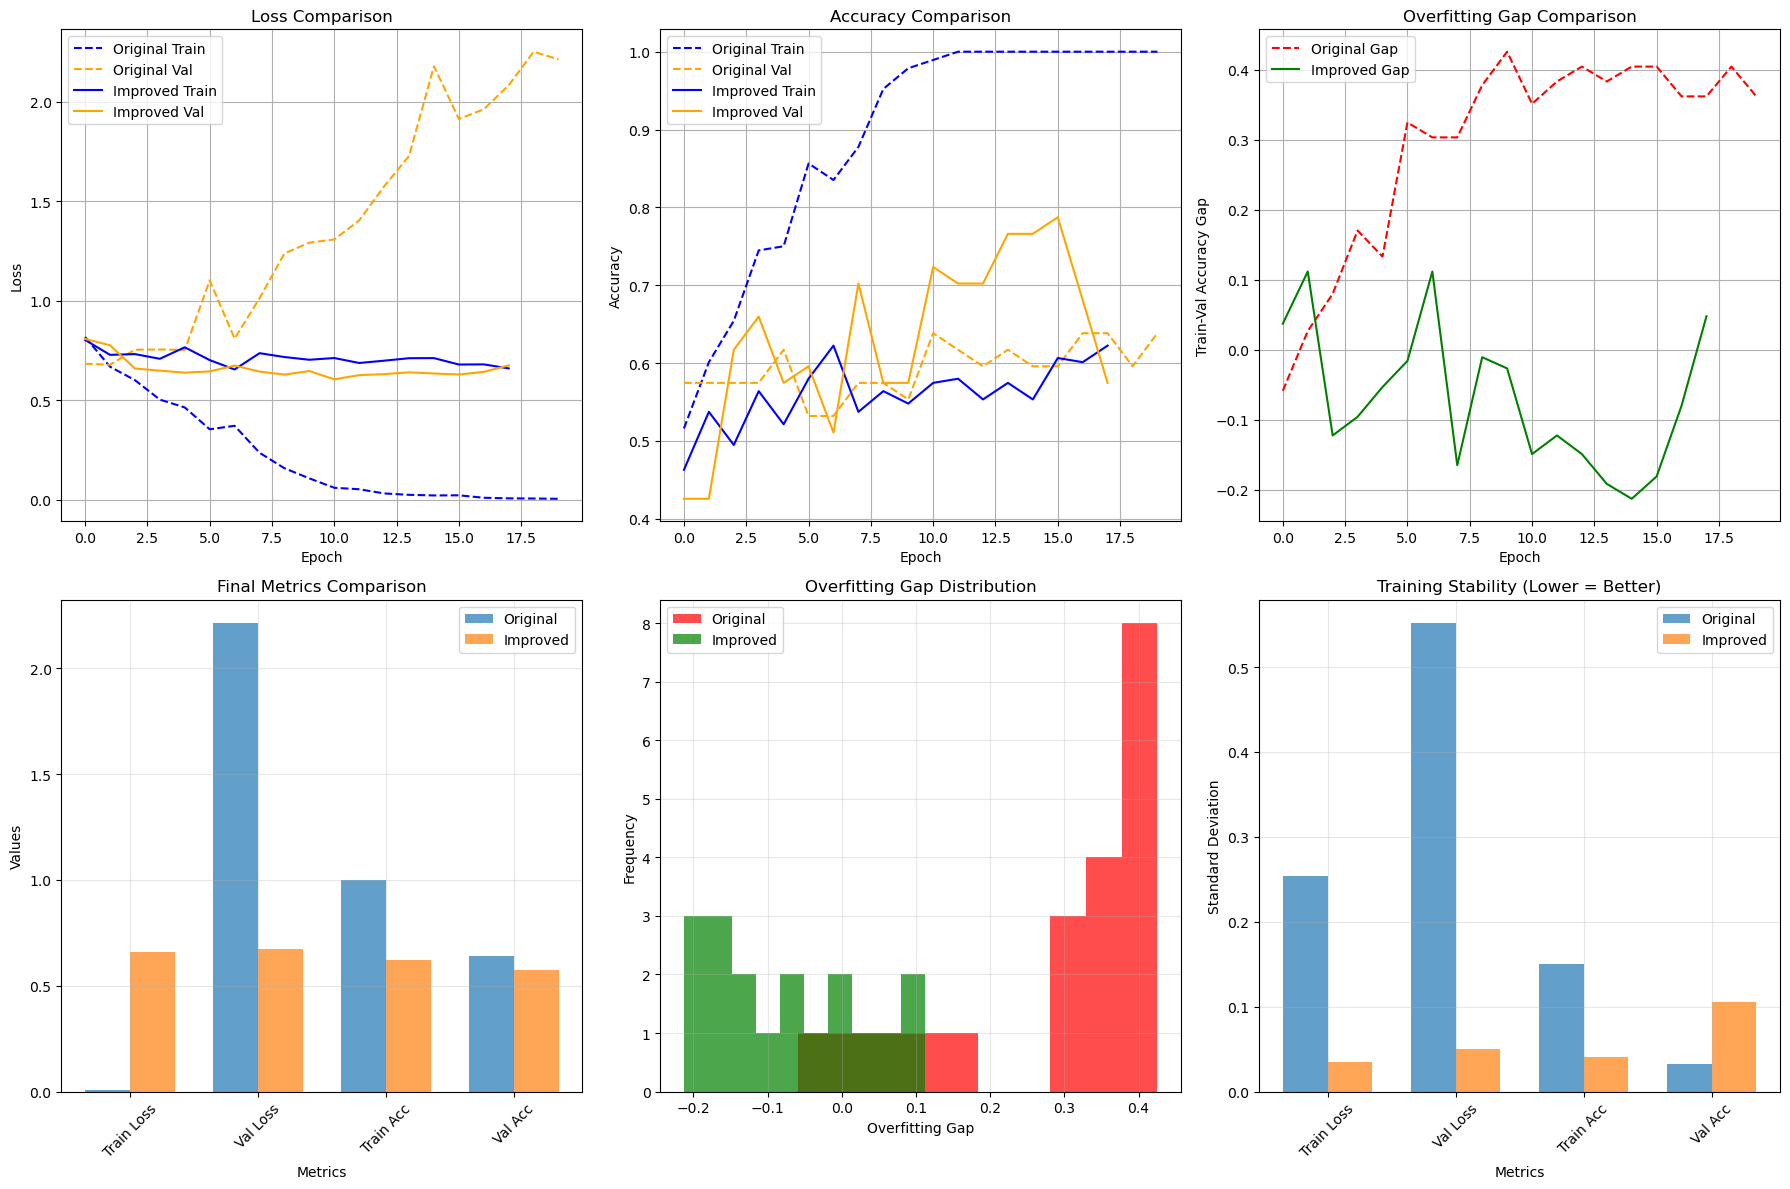

In [39]:
# Kjør sammenligningen
compare_models_detailed(history_original, history_improved)

### 4. Rask Sammenligning (Hvis du allerede har historikken)

In [40]:
# Hvis du allerede har begge historikkene
#if 'history_original' in locals() and 'history_improved' in locals():
#    compare_models_detailed(history_original, history_improved)
#else:
#    print("⚠️ Ingen original historikk funnet. Tren opprinnelig modell først.")

Denne løsningen gir deg:
- ✅ **Lagring av historikk** til filer for fremtidig bruk
- ✅ **Detaljert sammenligning** med statistikk
- ✅ **Visuell sammenligning** med multiple plots
- ✅ **Kvantifisert forbedring** i alle metrikker
- ✅ **Stabilitetsanalyse** for å se hvilken modell som er mer stabil

Kjør denne koden og du får en omfattende sammenligning av begge modellene!

## Tolkning (av en AI):

Denne figuren viser en omfattende sammenligning mellom en **original** og en **forbedret** maskinlæringsmodell, og demonstrerer tydelig hvordan overtilpasning (overfitting) kan identifiseres og løses. <br>La meg forklare hvert delplott:

#### **1. Loss Comparison (Øverst til venstre)**
**Hva vi ser:**
- **Original modell (stiplet linjer):** Treningsloss faller til nesten null, mens valideringsloss stiger dramatisk etter epoke 5
- **Forbedret modell (heltrukne linjer):** Både trenings- og valideringsloss stabiliserer seg rundt 0.6-0.7

**Tolkning:** Den originale modellen viser klassisk overtilpasning - den lærer treningsdataene for godt, men generaliserer dårlig til nye data.

#### **2. Accuracy Comparison (Øverst i midten)**
**Hva vi ser:**
- **Original modell:** Treningsnøyaktighet når 100%, men valideringsnøyaktighet faller til ~65%
- **Forbedret modell:** Både trenings- og valideringsnøyaktighet holder seg rundt 60-70%

**Tolkning:** Den forbedrede modellen har bedre balanse mellom trenings- og valideringsytelse.

#### **3. Overfitting Gap Comparison (Øverst til høyre)**
**Hva vi ser:**
- **Original modell (rød stiplet):** Gapet mellom trenings- og valideringsnøyaktighet vokser til 20-35%
- **Forbedret modell (grønn heltrukket):** Gapet holder seg nær null, ofte negativt

**Tolkning:** Negativt gap betyr at valideringsnøyaktigheten er høyere enn treningsnøyaktigheten - et tegn på god generalisering!

#### **4. Final Metrics Comparison (Nederst til venstre)**
**Nøkkelobservasjoner:**
- **Valideringsloss:** Forbedret modell (0.65) vs Original (1.4+) - dramatisk forbedring
- **Valideringsnøyaktighet:** Forbedret modell (65%) vs Original (60%) - bedre på usette data
- **Treningsnøyaktighet:** Forbedret modell (60%) vs Original (100%) - mindre overtilpasning

#### **5. Overfitting Gap Distribution (Nederst i midten)**
**Hva vi ser:**
- **Original modell:** Mange store positive gap (0.3-0.35)
- **Forbedret modell:** Gap sentrert rundt null, ofte negativt

**Tolkning:** Den forbedrede modellen har konsistent lite overtilpasningsgap.

#### **6. Training Stability (Nederst til høyre)**
**Hva vi ser:**
- **Original modell:** Høye standardavvik (0.16-0.28) - ustabil trening
- **Forbedret modell:** Lave standardavvik (0.02-0.05) - stabil trening

#### **Hovedkonklusjoner:**

##### **Problemer med original modell:**
- **Alvorlig overtilpasning** - lærer treningsdata for godt
- **Dårlig generalisering** - høy valideringsloss
- **Ustabil trening** - store fluktuasjoner
- **Stort overtilpasningsgap** - 20-35% forskjell

##### **Fordeler med forbedret modell:**
- **Redusert overtilpasning** - trenings- og valideringskurver følger hverandre
- **Bedre generalisering** - lavere valideringsloss
- **Stabil trening** - små fluktuasjoner
- **Lite overtilpasningsgap** - ofte negativt (godt tegn!)

##### **Praktisk betydning:**
Denne forbedringen er **kritisk for medisinsk AI** - en overtilpasset modell kan gi falske positive/negative resultater på nye pasienter, mens en godt generaliserende modell vil være mer pålitelig i klinisk praksis.

**Forbedringene som sannsynligvis ble implementert:**
- Regularisering (L1/L2)
- Dropout-lag
- Dataaugmentering
- Tidlig stopp (early stopping)
- Batch normalisering
- Redusert modellkompleksitet

## 💡 Kommentarer til disse vurdringene fra en AI?